# Moment dynamics with cell division

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)

---

In [44]:
import os
import pickle
import cloudpickle
import itertools
import glob

# Our numerical workhorses
import numpy as np
import scipy as sp
import pandas as pd

# Import library to perform maximum entropy fits
from maxentropy.skmaxent import FeatureTransformer, MinDivergenceModel

# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'
figdir = '../../fig/moment_dynamics_numeric/'
datadir = '../../data/csv_maxEnt_dist/'

### $\LaTeX$ macros
$\newcommand{kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{kron}{k^{(r)}_{\text{on}}}$
$\newcommand{kroff}{k^{(r)}_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{\ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\bb}[1]{\mathbf{#1}}$
$\newcommand{\dt}[1]{{\partial{#1} \over \partial t}}$
$\newcommand{\Km}{\bb{K}}$
$\newcommand{\Rm}{\bb{R}_m}$
$\newcommand{\Gm}{\bb{\Gamma}_m}$
$\newcommand{\Rp}{\bb{R}_p}$
$\newcommand{\Gp}{\bb{\Gamma}_p}$

## Distribution moment dynamics with cell division 

As first discussed by [Jones et al.](http://science.sciencemag.org/content/346/6216/1533) and then further expanded by [Peterson et al.](http://www.pnas.org/content/112/52/15886) the effect of having multiple gene copy numbers due to genome replication during the cell cycle has an important effect on gene expression noise. As the genome is replicated the cells spend part of their cell cycle with > 1 copy of the gene. The number of copies depends on the growth rate and on the gene position relative to the genome replication origin.

For our experimental setup our cells spend 40% of the cell cycle with 2 copies of the reporter gene and 40% with one copy. We previously inferred the parameters $\kpon$, $\kpoff$, and $r_m$ assuming that at both stages the mRNA reached steady state with $r_m$ as production rate for 1 gene copy and $2 r_m$ for two copies. The objective of this notebook is to explore the dynamical consequences of these gene copy number variations at the level of the mRNA and protein distribution moments.

The first thing we need to establish are the dynamics for the mRNA. The cell doubling time $t_d \approx 100$ min establishes the period of the cell cycle. For a time $0 < t_s < t_d$ cells have 1 copy of the gene (i.e. mRNA production rate $r_m$) and for the rest of the cycle the cells have 2 copies of the gene (i.e. mRNA production rate of $2 r_m$).

Therefore for our simulations we will initialize the moments at the steady state values for the single promoter, run the simulation with those parameters for time 0 to $t_s$ and then change the parameters for the rest of the simulation until reaching time $t_d$.

### Cell division

After cells reach time $t_d$ the content of the cells is assumed to divide as the cells split into two daughter cells. To account for this division we will assume that the mean mRNA (and later on protein) count are halved. Given the dependence of higher moments on the first moment we will "re-initialize" the value of the other moments assuming the values that one would obtain if this halved mean mRNA count was the steady state value. 

In other words assume that the mean mRNA count at time $t_d$ is given by $\ee{m(t_d)}$. After this time we reset the initial condition for the simulation with one promoter to be $\ee{m(t=0)} = {\ee{m(t_d)} \over 2}$. By fixing the first moment values higher moments of the mRNA distirbution $\ee{m^x}$ will be computed by finding what the steady state value would be given the value of the first moment. Note that this will not strictly give the same values as just computing the steady state value of the moments. If the initial condition $\ee{m(t=0)}$ is not the same as steady state condition $\ee{m}_{ss}$ the values that the other moments will also differ from the steady state values.

The reason for this convoluted assumption is that dividing the first moment in half after cell division makes sense, but it is not clear that the same assumption applies for higher moments of the distribution. To gain intuition about this assume that the mRNA distribution is binomial with mean value $\ee{m(t_d)} = N p$. Dividing this by half for the initial condition is easy since we would have $\ee{m(t=0)} = {N p \over 2}$. The second moment before the cell division would be of the form $\ee{m^2(t_d)} = Np - Np^2 + N^2p^2$. Therefore dividing this value by two for the initial condition of the next cell cycle doesn't translate to the second moment one would expect for a binomial distribution with mean ${Np \over 2}$.

# Defining promoter parameters

Before starting all the calculations we will define the kinetic parameters for the promoter.

In [2]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60)

# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double_expo.pkl',
          'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm

# Define protein production and degradatino rates
gp = 1 / (60 * 100) # sec^-1
rp = 1000 * gp # sec^-1

## Defining mRNA dynamics 

Let's begin by working with the mRNA dynamics only. We will define functions to compute the first 3 mRNA distribution moments. The ODEs that define these moments are given by
\begin{align}
% zeroth moment
{d \over dt} \ee{\bb{m}^0} &= \Km \left\langle \mathbf{m}^0 \right\rangle, \\
%first moment
{d \over dt}\ee{\bb{m}^1} &= 
\left( \Km - \Gm  \right)\ee{\bb{m}^1}
             + \Rm \left\langle \mathbf{m}^0 \right\rangle, \\
% second moment
{d\ee{\bb{m}^2} \over dt} &= \left( \Km - 2 \Gm \right) 
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 2 \Rm + \Gm \right)
             \left\langle \mathbf{m}^1 \right\rangle
             + \Rm
             \left\langle \mathbf{m}^0 \right\rangle,  \\
% third moment
{d\ee{\bb{m}^3} \over dt} &= \left( \Km - 3 \Gm \right) 
             \left\langle \mathbf{m}^3 \right\rangle
             + \left( 3 \Rm + 3 \Gm \right)
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 3 \Rm - \Gm \right)
             \left\langle \mathbf{m}^1 \right\rangle
             + \Rm
             \left\langle \mathbf{m}^0 \right\rangle.
\end{align}

Let's define a function `dmdt` to be fed to our ODE numerical integrator that computes these moments given some inital conditions.

We will also define a function `dm_dt_init` that takes the zeroth moment and the first moment out of the numerical integration. This function will be used to compute the inital conditions for higher moments after the cell division as explained before.

In [3]:
def dmdt(m, t, Kmat, Rmat, Gmat):
    '''
    function to integrate dm / dt using scipy.integrate.odeint
    Parameters
    ----------
    m : array-like.
        Array containing the zeroth, first, second and third moment 
        of the states of the promoter.
        Unregulated
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m1_P (RNAP bound)
        m[3] = m1_P (Empty promoter)
        m[4] = m2_P (RNAP bound)
        m[5] = m2_P (Empty promoter)
        m[6] = m3_P (RNAP bound)
        m[7] = m3_P (Empty promoter)
        ---------
        Regulated:
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m0_R (Repressor bound) 
        m[3] = m1_P (RNAP bound)
        m[4] = m1_E (Empty promoter)
        m[5] = m1_R (Repressor bound) 
        m[6] = m2_P (RNAP bound)
        m[7] = m2_E (Empty promoter)
        m[8] = m2_R (Repressor bound) 
        m[9] = m3_P (RNAP bound)
        m[10] = m3_E (Empty promoter)
        m[11] = m3_R (Repressor bound) 
    t : array-like.
        Time array
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rmat : array-like.
        Matrix containing the production rate at each of the states.
    Gmat : array-like.
        Matrix containing the degradation rate at each of the states.   
        
    Returns
    -------
    numerical integration of the differential equations
    '''
    # Obtain the zeroth and first moment based on the size 
    # of the Kmat matrix
    if Kmat.shape[0] == 2:
        m0 = m[0:2]
        m1 = m[2:4]
        m2 = m[4:6]
        m3 = m[6::]
    elif Kmat.shape[0] == 3:
        m0 = m[0:3]
        m1= m[3:6]
        m2= m[6:9]
        m3= m[9::]
    
    # Compute the moment equations for the:
    # Zeroth moment
    dm0dt_eq = np.dot(Kmat, m0)
    # First moment
    dm1dt_eq = np.dot((Kmat - Gmat), m1) + np.dot(Rmat, m0)
    # Second moment
    dm2dt_eq = np.dot((Kmat - 2 * Gmat), m2) + np.dot((2 * Rmat + Gmat), m1) +\
                np.dot(Rmat, m0)
    # Third moment
    dm3dt_eq = np.dot((Kmat - 3 * Gmat), m3) +\
                np.dot((3 * Rmat + 3 * Gmat), m2) +\
                np.dot((3 * Rmat - Gmat), m1) +\
                np.dot(Rmat, m0)
    
    return np.append(dm0dt_eq, 
                     np.append(dm1dt_eq, 
                               np.append(dm2dt_eq, dm3dt_eq)))

def dmdt_init(m, t, m_fix, Kmat, Rmat, Gmat):
    '''
    function to integrate dm / dt using scipy.integrate.odeint
    This funciton assumes that the zeroth and first moment are fixed
    and computes the corresponding second and third moments accordingly.
    Parameters
    ----------
    m : array-like.
        Array containing the second and third moment 
        of the states of the promoter.
        Unregulated
        m[0] = m2_P (RNAP bound)
        m[1] = m2_E (Empty promoter)
        m[2] = m3_P (RNAP bound)
        m[3] = m3_E (Empty promoter)
        ---------
        Regulated: 
        m[0] = m2_P (RNAP bound)
        m[1] = m2_E (Empty promoter)
        m[2] = m2_R (Repressor bound) 
        m[3] = m3_P (RNAP bound)
        m[4] = m3_E (Empty promoter)
        m[5] = m3_R (Repressor bound)    
    t : array-like.
        Time array
    m_fix : array-like.
        Array containing the zerot and first moment 
        of the states of the promoter that will remain fixed.
        Unregulated
        m_fix[0] = m0_P (RNAP bound)
        m_fix[1] = m0_E (Empty promoter)
        m_fix[2] = m1_P (RNAP bound)
        m_fix[3] = m1_E (Empty promoter)
    ---------
    Regulated:
        m_fix[0] = m0_P (RNAP bound)
        m_fix[1] = m0_E (Empty promoter)
        m_fix[2] = m0_R (Repressor bound) 
        m_fix[3] = m1_P (RNAP bound)
        m_fix[4] = m1_E (Empty promoter)
        m_fix[5] = m1_R (Repressor bound)
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rmat : array-like.
        Matrix containing the production rate at each of the states.
    Gmat : array-like.
        Matrix containing the degradation rate at each of the states.   
        
    Returns
    -------
    2nd and 3rd moment dynamics given fixed 0th and 1st moment
    '''
    # Obtain the zeroth and first moment based on the size 
    # of the Kmat matrix
    if Kmat.shape[0] == 2:
        m0 = m_fix[0:2]
        m1 = m_fix[2::]
        m2 = m[0:2]
        m3 = m[2::]
    elif Kmat.shape[0] == 3:
        m0 = m_fix[0:3]
        m1= m_fix[3::]
        m2= m[0:3]
        m3= m[3::]
    
    # Compute the moment equations for the:
    # Second moment
    dm2dt_eq = np.dot((Kmat - 2 * Gmat), m2) + np.dot((2 * Rmat + Gmat), m1) +\
                np.dot(Rmat, m0)
    # Third moment
    dm3dt_eq = np.dot((Kmat - 3 * Gmat), m3) +\
                np.dot((3 * Rmat + 3 * Gmat), m2) +\
                np.dot((3 * Rmat - Gmat), m1) +\
                np.dot(Rmat, m0)
    
    return np.append(dm2dt_eq, dm3dt_eq)

### Defining function to compute moments over severall cell cycles

Having defined the functions to integrate the moment ODEs let's now define a function that given a time `t_single` that cells spend with one promoter copy and a time `t_double` that cells spend with two copies integrates the moments over several cell cycles.

In [4]:
def dmdt_cycles(m_init, t_single, t_double, n_cycles, 
                Kmat, Rmat, Gmat, n_steps=1000, t_ss=10000,
                states=['P', 'E']):
    '''
    Function that integrates the mRNA moments over several cell cycles.
    Parameters
    ----------
    m : array-like.
        Array containing the zeroth, first, second and third moment 
        of the states of the promoter.
        Unregulated
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m1_P (RNAP bound)
        m[3] = m1_E (Empty promoter)
        m[4] = m2_P (RNAP bound)
        m[5] = m2_E (Empty promoter)
        m[6] = m3_P (RNAP bound)
        m[7] = m3_E (Empty promoter)
        ---------
        Regulated:
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m0_R (Repressor bound) 
        m[3] = m1_P (RNAP bound)
        m[4] = m1_E (Empty promoter)
        m[5] = m1_R (Repressor bound) 
        m[6] = m2_P (RNAP bound)
        m[7] = m2_E (Empty promoter)
        m[8] = m2_R (Repressor bound) 
        m[9] = m3_P (RNAP bound)
        m[10] = m3_E (Empty promoter)
        m[11] = m3_R (Repressor bound)
    t_single : float.
        Time [in 1/mRNA degradation rate units] that cells spend 
        with a single promoter copy
    t_double : float.
        Time [in 1/mRNA degradation rate units] that cells spend 
        with a two promoter copies.
    n_cycles : int.
        Number of cell cycles to integrate for. A cell cycle is defined
        as t_single + t_double.
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rmat : array-like.
        Matrix containing the production rate at each of the states.
    Gmat : array-like.
        Matrix containing the degradation rate at each of the states.
    n_steps : int. Default = 300.
        Number of steps to use for the numerical integration.
    t_ss : float.
        Time to integrate for after cell division to compute the steady
        state value of higher moments.
    states : array-like. Default = ['P', 'E']
        Array containing the strings that define the moments that the
        promoter can be found at. For an unregulated promoter the only
        two available states are 'P' (RNAP bound) and 'E' (empty).
        For the regulated case a third state 'R' (repressor bound) is
        available to the system.

    Returns
    -------
    mRNA moment dynamics over cell cycles
    '''
    # Initialize names for moments in data frame
    names = ['m' + str(mom) + '_' + st for mom in range(4) for st in states]
    
    # Initialize data frame
    df = pd.DataFrame(columns=['time', 'state', 'cycle'] + names)
    
    # Initilaize global time
    t_sim = 0
    # Loop through cycles
    for cyc in range(n_cycles):
        # == Single promoter == #
        # Define time array
        t = np.linspace(0, t_single, n_steps)

        # Integrate moment equations
        m = sp.integrate.odeint(dmdt, m_init, t, 
                             args=(Kmat, Rmat, Gmat))

        # Generate data frame
        df_m = pd.DataFrame(m, columns=names)
        # Append time, state and cycle
        df_m = df_m.assign(time=t + t_sim)
        df_m = df_m.assign(state=['single'] * m.shape[0])
        df_m = df_m.assign(cycle=[cyc] * m.shape[0])
        
        # Append results to global data frame
        df = df.append(df_m, ignore_index=True, sort=False)
        
        # Update global time
        t_sim = t_sim + t[-1]
        
        # == Two promoters == #
        
        # Define initial conditions as last point of single promoter state
        m_init = m[-1, :]
        
        # Define time array
        t = np.linspace(0, t_double, n_steps)

        # Integrate moment equations
        m = sp.integrate.odeint(dmdt, m_init, t, 
                             args=(Kmat, 2 * Rmat, Gmat))

        # Generate data frame
        df_m = pd.DataFrame(m, columns=names)
        # Append time, state and cycle
        df_m = df_m.assign(time=t + t_sim)
        df_m = df_m.assign(state=['double'] * m.shape[0])
        df_m = df_m.assign(cycle=[cyc] * m.shape[0])
        
        # Append results to global data frame
        df = df.append(df_m, ignore_index=True, sort=False)
        
        # Update global time
        t_sim = t_sim + t[-1]
        
        # == Cell division == #
        
        # Define time array
        t = np.linspace(0, t_ss, n_steps)
        
        # Define initial conditions as last point of single promoter state
        m_fix = m[-1, 0:(Kmat.shape[0]*2)]
        # Divide mean mRNA by half
        m_fix[(Kmat.shape[0])::] = m_fix[(Kmat.shape[0])::] / 2
        # Set initial condiitons for higher moments.
        m_init = m[-1, (Kmat.shape[0]*2)::]
        
        # Define initial conditions for moments after cell division
        m = sp.integrate.odeint(dmdt_init, m_init, t, 
                             args=(m_fix, Kmat, Rmat, Gmat))
        
        m_init = np.append(m_fix, m[-1, :])
        
    return df

# Two-state promoter
Having defined these functions let's first test them with the two-state unregulated promoter.

Now we will define the state transition matrix $\Km$, the mRNA production matrix $\Rm$ and the mRNA degradation matrix $\Gm$.

In [5]:
# Define the rate constant matrix
Kmat_unreg = np.array([[-kp_off, kp_on], 
                       [kp_off, -kp_on]])
# Define the production matrix
Rmat_unreg = np.array([[rm, 0], 
                       [0, 0]])
# Define the degradation matrix
Gmat_unreg = np.array([[gm, 0],
                       [0, gm]])

Let's integrate the equations for a long time to obtain the initial condition. For this we will initialize the zeroth moment all with equal probability, and the rest of the moments at zero. Running the integration for a long time will allow all of the moments to reach their steady state that we will use as our inital condition for the actual cell cycle integration.

In [6]:
# Define time on which to perform integration
t = np.linspace(0, 100 * 60, 301)

# Define initial conditions
m0_init = [0.5, 0.5]
m1_init = [0, 0]
m2_init = [0, 0]
m3_init = [0, 0]

# Numerically integrate equations
m_init = sp.integrate.odeint(dmdt, m0_init + m1_init + m2_init + m3_init, t, 
                             args=(Kmat_unreg, Rmat_unreg, Gmat_unreg))

# Define the inital conditions as the last point in this integration.
m_init = m_init[-1, :]

Let's now define the necesary inputs and run the numerical integration for several cell cycles.

In [7]:
# Define time for single-promoter state
t_single = 60 * 0.6 * 100 # sec

# Define time for two-promoter state
t_double = 60 * 0.4 * 100 # sec

# Define number of cell cycles
n_cycles = 4

# Integrate moment equations
df = dmdt_cycles(m_init, t_single, t_double, n_cycles, 
                 Kmat_unreg, Rmat_unreg, Gmat_unreg)

df_m_unreg = df

Now let's plot the first mRNA moment. For this we first need to extract all the first moments for each of the promoter states and add them together to get the global first moment.

In [8]:
# Extract index for first and second moment
first_mom_names = [x for x in df_m_unreg.columns if 'm1' in x]

# Compute the mean mRNA copy number
m_mean = df_m_unreg.loc[:, first_mom_names].sum(axis=1)

Now we can plot the mean.

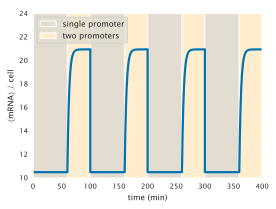

In [9]:
# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Plot mean mRNA as solid line
ax.plot(df_m_unreg.time / 60, m_mean, label='', lw=2.2)

# Group data frame by cell cycle
df_group = df_m_unreg.groupby('cycle')
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df_m_unreg['cycle'].max():
        label_s = 'single promoter'
        label_d = 'two promoters'
    else:
        label_s = ''
        label_d = ''
    # Find index for one-promoter state
    idx = np.where(data.state == 'single')[0]
    # Indicate states with two promoters
    ax.axvspan(data.iloc[idx.min()]['time'] / 60, data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    
    # Find index for two-promoter state
    idx = np.where(data.state == 'double')[0]
    # Indicate states with two promoters
    ax.axvspan(data.iloc[idx.min()]['time'] / 60, data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)

# Set limits
ax.set_xlim(df['time'].min() / 60, df['time'].max() / 60)
ax.set_ylim(top=24)
# Label plot
ax.set_xlabel('time (min)')
ax.set_ylabel(r'$\left\langle \right.$mRNA$\left. \right\rangle$ / cell')

ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig(figdir + 'mean_mRNA_cycles.pdf', bbox_inches='tight')

We can see from this plot that the mRNA indeed seems to reach a steady state both when cells have one copy of the promoter, and when cells have two copies. This was expected given that the way that the mRNA production parameters were inferred in the first place assumed this steady state. This is just a confirmation that our numerical integration of the moment equations makes sense with what we expect.

It is important to highlight that we do not necessarily expect the same result for proteins since the time to steady state is set by the degradation rate, and the protein degradation rate for bacteria is assumed to be the dilution rate due to cell division.

## Defining Protein dynamics 

Having worked out the mRNA dynamics let's extend this approach to the protein dynamics. First let's list the ODEs for the moments.

### Protein and cross correlation moments
\begin{align}
% first moment
{d \ee{\bb{p}^1}\over dt} &=
\left( \mathbf{K} - \Gp  \right) \ee{\bb{p}^1}
+ \Rp \left\langle \mathbf{m} \right\rangle.\\
% <mp>
{d \ee{\bb{mp}}\over dt} &=
\left( \mathbf{K} - \Gm -  \Gp  \right)
\left\langle \mathbf{mp} \right\rangle 
+ \Rm \left\langle \mathbf{p} \right\rangle
+ \Rp \left\langle \mathbf{m}^2 \right\rangle \\
% second moment
{d \ee{\bb{p}^2}\over dt} &=
\left( \mathbf{K} - 2 \Gp \right) 
\left\langle \mathbf{p}^2 \right\rangle
+ \Gp \left\langle \mathbf{p} \right\rangle
+ \Rp \mm
+ 2 \Rp \left\langle \mathbf{mp} \right\rangle \\
% <m^2p>
{d \ee{\bb{m}^2\bb{p}}\over dt} &=   
\left( \bb{K} - 2 \bb{\Gamma}_m - \Gp \right) 
\ee{\bb{m}^2\bb{p}} +
\bb{R}_m \ee{\bb{p}} +
\left( 2 \bb{R}_m + \bb{\Gamma}_m \right) \ee{\bb{mp}} +
\bb{R}_p \ee{\bb{m}^3}.\\
% <mp^2>
{d \ee{\bb{m}\bb{p}^2}\over dt} &=   
\left( \bb{K} - \bb{\Gamma}_m - 2 \Gp \right)
\ee{\bb{mp}^2} +
\bb{R}_m \ee{\bb{p}^2} +
2 \bb{R}_p \ee{\bb{m}^2\bb{p}} +
\bb{R}_p \ee{\bb{m}^2} +
\Gp \ee{\bb{mp}}.\\
% third moment
{d \ee{\bb{p}^3}\over dt} &=
\left( \bb{K} - 3 \Gp \right) \ee{\bb{p}^3} +
3 \Gp \ee{\bb{p}^2} -
\Gp \ee{\bb{p}} +
3 \bb{R}_p \ee{\bb{mp}^2} +
3 \bb{R}_p \ee{\bb{mp}} +
\bb{R}_p \ee{\bb{m}}.
\end{align}

We now implement these equations into a function `dpdt`. And just as with the mRNA case we will define a function to compute the initial conditions after cell division `dpdt_init` that keeps the zeroth moment as well as the first mRNA moment $\ee{\bb{m}}$ and the first protein moment $\ee{\bb{p}}$ fixed, integrating all other moments.

In [6]:
def dpdt(mp, t, Kmat, Rm, Gm, Rp, Gp):
    '''
    function to integrate all mRNA and protein moment dynamics
    using scipy.integrate.odeint
    Parameters
    ----------
    m : array-like.
        Array containing all moments (mRNA, protein and cross correlations) 
        Unregulated
        mp[0] = m0_P (RNAP bound)
        mp[1] = m0_E (Empty promoter)
        mp[2] = m1_P (RNAP bound)
        mp[3] = m1_P (Empty promoter)
        mp[4] = m2_P (RNAP bound)
        mp[5] = m2_P (Empty promoter)
        mp[6] = m3_P (RNAP bound)
        mp[7] = m3_P (Empty promoter)
        mp[8] = p1_P (RNAP bound)
        mp[9] = p1_P (Empty promoter)
        mp[10] = mp_P (RNAP bound)
        mp[11] = mp_P (Empty promoter)
        mp[12] = p2_P (RNAP bound)
        mp[13] = p2_P (Empty promoter)
        mp[14] = m2p_P (RNAP bound)
        mp[15] = m2p_P (Empty promoter)
        mp[16] = mp2_P (RNAP bound)
        mp[17] = mp2_P (Empty promoter)
        mp[18] = p3_P (RNAP bound)
        mp[19] = p3_P (Empty promoter)
        ---------
        Regulated:
        mp[0] = m0_P (RNAP bound)
        mp[1] = m0_E (Empty promoter)
        mp[2] = m0_R (Repressor bound) 
        mp[3] = m1_P (RNAP bound)
        mp[4] = m1_E (Empty promoter)
        mp[5] = m1_R (Repressor bound) 
        mp[6] = m2_P (RNAP bound)
        mp[7] = m2_E (Empty promoter)
        mp[8] = m2_R (Repressor bound) 
        mp[9] = m3_P (RNAP bound)
        mp[10] = m3_E (Empty promoter)
        mp[11] = m3_R (Repressor bound) 
        mp[12] = p1_P (RNAP bound)
        mp[13] = p1_E (Empty promoter)
        mp[14] = p1_R (Repressor bound) 
        mp[15] = mp_P (RNAP bound)
        mp[16] = mp_E (Empty promoter)
        mp[17] = mp_R (Repressor bound) 
        mp[18] = p2_P (RNAP bound)
        mp[19] = p2_E (Empty promoter)
        mp[20] = p2_R (Repressor bound) 
        mp[21] = m2p_P (RNAP bound)
        mp[22] = m2p_E (Empty promoter)
        mp[23] = m2p_R (Repressor bound) 
        mp[24] = mp2_P (RNAP bound)
        mp[25] = mp2_E (Empty promoter)
        mp[26] = mp2_R (Repressor bound) 
        mp[27] = p3_P (RNAP bound)
        mp[28] = p3_E (Empty promoter)
        mp[29] = p3_R (Repressor bound) 
    t : array-like.
        Time array
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rm : array-like.
        Matrix containing the mRNA production rate at each of the states.
    Gm : array-like.
        Matrix containing the mRNA degradation rate at each of the states.   
    Rp : array-like.
        Matrix containing the protein production rate at each of the states.
    Gp : array-like.
        Matrix containing the protein degradation rate at each of the states.       

    Returns
    -------
    dynamics of all mRNA and protein moments
    '''
    # Obtain the zeroth and first moment based on the size
    # of the Kmat matrix
    if Kmat.shape[0] == 2:
        m0 = mp[0:2]
        m1 = mp[2:4]
        m2 = mp[4:6]
        m3 = mp[6:8]
        p1 = mp[8:10]
        mp1 = mp[10:12]
        p2 = mp[12:14]
        m2p = mp[14:16]
        mp2 = mp[16:18]
        p3 = mp[18::]
    elif Kmat.shape[0] == 3:
        m0 = mp[0:3]
        m1 = mp[3:6]
        m2 = mp[6:9]
        m3 = mp[9:12]
        p1 = mp[12:15]
        mp1 = mp[15:18]
        p2 = mp[18:21]
        m2p = mp[21:24]
        mp2 = mp[24:27]
        p3 = mp[27::]

    # Initialize array to save all dynamics
    dmpdt = np.array([])

    # Compute the moment equations for the:
    #=== mRNA ===#
    # Zeroth moment
    dm0dt_eq = np.dot(Kmat, m0)
    dmpdt = np.append(dmpdt, dm0dt_eq)
    # <m1>
    dm1dt_eq = np.dot((Kmat - Gm), m1) + np.dot(Rm, m0)
    dmpdt = np.append(dmpdt, dm1dt_eq)
    # <m2>
    dm2dt_eq = np.dot((Kmat - 2 * Gm), m2) + np.dot((2 * Rm + Gm), m1) +\
        np.dot(Rm, m0)
    dmpdt = np.append(dmpdt, dm2dt_eq)
    # <m3>
    dm3dt_eq = np.dot((Kmat - 3 * Gm), m3) +\
        np.dot((3 * Rm + 3 * Gm), m2) +\
        np.dot((3 * Rm - Gm), m1) +\
        np.dot(Rm, m0)
    dmpdt = np.append(dmpdt, dm3dt_eq)
    #=== protein and correlations ===#
    # <p1>
    dp1dt_eq = np.dot((Kmat - Gp), p1) + np.dot(Rp, m1)
    dmpdt = np.append(dmpdt, dp1dt_eq)
    # <mp>
    dmpdt_eq = np.dot((Kmat - Gm - Gp), mp1) +\
        np.dot(Rm, p1) +\
        np.dot(Rp, m2)
    dmpdt = np.append(dmpdt, dmpdt_eq)
    # <p2>
    dp2dt_eq = np.dot((Kmat - 2 * Gp), p2) +\
        np.dot(Gp, p1) +\
        np.dot(Rp, m1) +\
        np.dot((2 * Rp), mp1)
    dmpdt = np.append(dmpdt, dp2dt_eq)
    # <m2p>
    dm2pdt_eq = np.dot((Kmat - 2 * Gm - Gp), m2p) +\
        np.dot(Rm, p1) +\
        np.dot((2 * Rm + Gm), mp1) +\
        np.dot(Rp, m3)
    dmpdt = np.append(dmpdt, dm2pdt_eq)
    # <mp2>
    dmp2dt_eq = np.dot((Kmat - Gm - 2 * Gp), mp2) +\
        np.dot(Rm, p2) +\
        np.dot((2 * Rp), m2p) +\
        np.dot(Rp, m2) +\
        np.dot(Gp, mp1)
    dmpdt = np.append(dmpdt, dmp2dt_eq)
    # <p3>
    dp3dt_eq = np.dot((Kmat - 3 * Gp), p3) +\
        np.dot((3 * Gp), p2) -\
        np.dot(Gp, p1) +\
        np.dot((3 * Rp), mp2) +\
        np.dot((3 * Rp), mp1) +\
        np.dot(Rp, m1)
    dmpdt = np.append(dmpdt, dp3dt_eq)

    return dmpdt

def dpdt_init(mp, t, m_fix, Kmat, Rm, Gm, Rp, Gp):
    '''
    function to integrate all mRNA and protein moment dynamics
    using scipy.integrate.odeint
    Parameters
    ----------
    m : array-like.
        Array containing all moments (mRNA, protein and cross correlations) 
        Unregulated
        mp[0] = m2_P (RNAP bound)
        mp[1] = m2_P (Empty promoter)
        mp[2] = m3_P (RNAP bound)
        mp[3] = m3_P (Empty promoter)
        mp[4] = p1_P (RNAP bound)
        mp[5] = p1_P (Empty promoter)
        mp[6] = mp_P (RNAP bound)
        mp[7] = mp_P (Empty promoter)
        mp[8] = p2_P (RNAP bound)
        mp[9] = p2_P (Empty promoter)
        mp[10] = m2p_P (RNAP bound)
        mp[11] = m2p_P (Empty promoter)
        mp[12] = mp2_P (RNAP bound)
        mp[13] = mp2_P (Empty promoter)
        mp[14] = p3_P (RNAP bound)
        mp[15] = p3_P (Empty promoter)
        ---------
        Regulated:
        mp[0] = m2_P (RNAP bound)
        mp[1] = m2_E (Empty promoter)
        mp[2] = m2_R (Repressor bound) 
        mp[3] = m3_P (RNAP bound)
        mp[4] = m3_E (Empty promoter)
        mp[5] = m3_R (Repressor bound) 
        mp[6] = p1_P (RNAP bound)
        mp[7] = p1_E (Empty promoter)
        mp[8] = p1_R (Repressor bound) 
        mp[9] = mp_P (RNAP bound)
        mp[10] = mp_E (Empty promoter)
        mp[11] = mp_R (Repressor bound) 
        mp[12] = p2_P (RNAP bound)
        mp[13] = p2_E (Empty promoter)
        mp[14] = p2_R (Repressor bound) 
        mp[15] = m2p_P (RNAP bound)
        mp[16] = m2p_E (Empty promoter)
        mp[17] = m2p_R (Repressor bound) 
        mp[18] = mp2_P (RNAP bound)
        mp[19] = mp2_E (Empty promoter)
        mp[20] = mp2_R (Repressor bound) 
        mp[21] = p3_P (RNAP bound)
        mp[22] = p3_E (Empty promoter)
        mp[23] = p3_R (Repressor bound)
    t : array-like.
        Time array
    m_fix : array-like.
        Array containing the zerot and first moment 
        of the states of the promoter that will remain fixed.
        Unregulated
        m_fix[0] = m0_P (RNAP bound)
        m_fix[1] = m0_E (Empty promoter)
        m_fix[2] = m1_P (RNAP bound)
        m_fix[3] = m1_E (Empty promoter)
    ---------
    Regulated:
        m_fix[0] = m0_P (RNAP bound)
        m_fix[1] = m0_E (Empty promoter)
        m_fix[2] = m0_R (Repressor bound) 
        m_fix[3] = m1_P (RNAP bound)
        m_fix[4] = m1_E (Empty promoter)
        m_fix[5] = m1_R (Repressor bound)
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rm : array-like.
        Matrix containing the mRNA production rate at each of the states.
    Gm : array-like.
        Matrix containing the mRNA degradation rate at each of the states.   
    Rp : array-like.
        Matrix containing the protein production rate at each of the states.
    Gp : array-like.
        Matrix containing the protein degradation rate at each of the states.       

    Returns
    -------
    dynamics of all mRNA and protein moments
    '''
    # Obtain the zeroth and first moment based on the size
    # of the Kmat matrix
    if Kmat.shape[0] == 2:
        m0 = m_fix[0:2]
        m1 = m_fix[2:4]
        p1 = m_fix[4::]
        
        m2 = mp[0:2]
        m3 = mp[2:4]
        mp1 = mp[4:6]
        p2 = mp[6:8]
        m2p = mp[8:10]
        mp2 = mp[10:12]
        p3 = mp[12::]
    elif Kmat.shape[0] == 3:
        m0 = m_fix[0:3]
        m1= m_fix[3:6]
        p1 = m_fix[6::]
        
        m2 = mp[0:3]
        m3 = mp[3:6]
        mp1 = mp[6:9]
        p2 = mp[9:12]
        m2p = mp[12:15]
        mp2 = mp[15:18]
        p3 = mp[18::]

    # Initialize array to save all dynamics
    dmpdt = np.array([])

    # Compute the moment equations for the:
    #=== mRNA ===#
    # <m2>
    dm2dt_eq = np.dot((Kmat - 2 * Gm), m2) + np.dot((2 * Rm + Gm), m1) +\
        np.dot(Rm, m0)
    dmpdt = np.append(dmpdt, dm2dt_eq)
    # <m3>
    dm3dt_eq = np.dot((Kmat - 3 * Gm), m3) +\
        np.dot((3 * Rm + 3 * Gm), m2) +\
        np.dot((3 * Rm - Gm), m1) +\
        np.dot(Rm, m0)
    dmpdt = np.append(dmpdt, dm3dt_eq)
    #=== protein and correlations ===#
    # <mp>
    dmpdt_eq = np.dot((Kmat - Gm - Gp), mp1) +\
        np.dot(Rm, p1) +\
        np.dot(Rp, m2)
    dmpdt = np.append(dmpdt, dmpdt_eq)
    # <p2>
    dp2dt_eq = np.dot((Kmat - 2 * Gp), p2) +\
        np.dot(Gp, p1) +\
        np.dot(Rp, m1) +\
        np.dot((2 * Rp), mp1)
    dmpdt = np.append(dmpdt, dp2dt_eq)
    # <m2p>
    dm2pdt_eq = np.dot((Kmat - 2 * Gm - Gp), m2p) +\
        np.dot(Rm, p1) +\
        np.dot((2 * Rm + Gm), mp1) +\
        np.dot(Rp, m3)
    dmpdt = np.append(dmpdt, dm2pdt_eq)
    # <mp2>
    dmp2dt_eq = np.dot((Kmat - Gm - 2 * Gp), mp2) +\
        np.dot(Rm, p2) +\
        np.dot((2 * Rp), m2p) +\
        np.dot(Rp, m2) +\
        np.dot(Gp, mp1)
    dmpdt = np.append(dmpdt, dmp2dt_eq)
    # <p3>
    dp3dt_eq = np.dot((Kmat - 3 * Gp), p3) +\
        np.dot((3 * Gp), p2) -\
        np.dot(Gp, p1) +\
        np.dot((3 * Rp), mp2) +\
        np.dot((3 * Rp), mp1) +\
        np.dot(Rp, m1)
    dmpdt = np.append(dmpdt, dp3dt_eq)

    return dmpdt

### Defining function to compute moments over severall cell cycles

Having defined the functions to integrate the moment ODEs let's now define a function that given a time `t_single` that cells spend with one promoter copy and a time `t_double` that cells spend with two copies integrates the moments over several cell cycles.

In [7]:
def dpdt_cycles(mp, t_single, t_double, n_cycles, 
                Kmat, Rm, Gm, Rp, Gp, n_steps=1000, t_ss=10000,
                moments=[(0, 0),
                         (1, 0), (2, 0), (3, 0),
                         (0, 1), (1, 1), (0, 2),
                         (2, 1), (1, 2), (0, 3)],
                states=['P', 'E']):
    '''
    Function that integrates the mRNA moments over several cell cycles.
    Parameters
    ----------
    mp : array-like.
        Array containing the zeroth, first, second and third moment 
        of the states of the promoter.
        Unregulated
        mp[0] = m0_P (RNAP bound)
        mp[1] = m0_E (Empty promoter)
        mp[2] = m1_P (RNAP bound)
        mp[3] = m1_P (Empty promoter)
        mp[4] = m2_P (RNAP bound)
        mp[5] = m2_P (Empty promoter)
        mp[6] = m3_P (RNAP bound)
        mp[7] = m3_P (Empty promoter)
        mp[8] = p1_P (RNAP bound)
        mp[9] = p1_P (Empty promoter)
        mp[10] = mp_P (RNAP bound)
        mp[11] = mp_P (Empty promoter)
        mp[12] = p2_P (RNAP bound)
        mp[13] = p2_P (Empty promoter)
        mp[14] = m2p_P (RNAP bound)
        mp[15] = m2p_P (Empty promoter)
        mp[16] = mp2_P (RNAP bound)
        mp[17] = mp2_P (Empty promoter)
        mp[18] = p3_P (RNAP bound)
        mp[19] = p3_P (Empty promoter)
        ---------
        Regulated:
        mp[0] = m0_P (RNAP bound)
        mp[1] = m0_E (Empty promoter)
        mp[2] = m0_R (Repressor bound) 
        mp[3] = m1_P (RNAP bound)
        mp[4] = m1_E (Empty promoter)
        mp[5] = m1_R (Repressor bound) 
        mp[6] = m2_P (RNAP bound)
        mp[7] = m2_E (Empty promoter)
        mp[8] = m2_R (Repressor bound) 
        mp[9] = m3_P (RNAP bound)
        mp[10] = m3_E (Empty promoter)
        mp[11] = m3_R (Repressor bound) 
        mp[12] = p1_P (RNAP bound)
        mp[13] = p1_E (Empty promoter)
        mp[14] = p1_R (Repressor bound) 
        mp[15] = mp_P (RNAP bound)
        mp[16] = mp_E (Empty promoter)
        mp[17] = mp_R (Repressor bound) 
        mp[18] = p2_P (RNAP bound)
        mp[19] = p2_E (Empty promoter)
        mp[20] = p2_R (Repressor bound) 
        mp[21] = m2p_P (RNAP bound)
        mp[22] = m2p_E (Empty promoter)
        mp[23] = m2p_R (Repressor bound) 
        mp[24] = mp2_P (RNAP bound)
        mp[25] = mp2_E (Empty promoter)
        mp[26] = mp2_R (Repressor bound) 
        mp[27] = p3_P (RNAP bound)
        mp[28] = p3_E (Empty promoter)
        mp[29] = p3_R (Repressor bound)
    t_single : float.
        Time [in 1/mRNA degradation rate units] that cells spend 
        with a single promoter copy
    t_double : float.
        Time [in 1/mRNA degradation rate units] that cells spend 
        with a two promoter copies.
    n_cycles : int.
        Number of cell cycles to integrate for. A cell cycle is defined
        as t_single + t_double.
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rm : array-like.
        Matrix containing the production rate at each of the states.
    Gm : array-like.
        Matrix containing the degradation rate at each of the states.
    Rp : array-like.
        Matrix containing the protein production rate at each of the states.
    Gp : array-like.
        Matrix containing the protein degradation rate at each of the states.       
    n_steps : int. Default = 300.
        Number of steps to use for the numerical integration.
    t_ss : float.
        Time to integrate for after cell division to compute the steady
        state value of higher moments.
    moments : list.
        List of moment exponents. For example if the first mRNA moment
        will be listed then the entry should be (1, 0). If the third
        protein moment will be computed then it should contain (0, 3).
        These should be given in the same order as the moment dynamics
        are returned by the funciton dpdt since they will serve to
        build the names of the columns in the data frame.
    states : list.
        String list containing the name of the promoter states. For example
        for a 3 promoter state this should be ['P', 'E', 'R'] for the RNAP
        bound state, the empty state and the repressor bound state 
        respectively. These should also be given in the order that the 
        matrices contain each of the states.

    Returns
    -------
    mRNA moment dynamics over cell cycles
    '''
    # Initialize names for moments in data frame
    names = ['m' + str(m[0]) + 'p' + str(m[1]) + st for m in moments
             for st in states]         
    
    # Initialize data frame
    df = pd.DataFrame(columns=['time', 'state', 'cycle'] + names)
    
    # Initilaize global time
    t_sim = 0
    # Loop through cycles
    for cyc in range(n_cycles):
        # == Single promoter == #
        # Define time array
        t = np.linspace(0, t_single, n_steps)

        # Integrate moment equations
        m = sp.integrate.odeint(dpdt, mp, t, 
                             args=(Kmat, Rm, Gm, Rp, Gp))

        # Generate data frame
        df_m = pd.DataFrame(m, columns=names)
        # Append time, state and cycle
        df_m = df_m.assign(time=t + t_sim)
        df_m = df_m.assign(state=['single'] * m.shape[0])
        df_m = df_m.assign(cycle=[cyc] * m.shape[0])
        
        # Append results to global data frame
        df = df.append(df_m, ignore_index=True, sort=False)
        
        # Update global time
        t_sim = t_sim + t[-1]
        
        # == Two promoters == #
        
        # Define initial conditions as last point of single promoter state
        mp = m[-1, :]
        
        # Define time array
        t = np.linspace(0, t_double, n_steps)

        # Integrate moment equations
        m = sp.integrate.odeint(dpdt, mp, t, 
                             args=(Kmat, 2 * Rm, Gm, Rp, Gp))

        # Generate data frame
        df_m = pd.DataFrame(m, columns=names)
        # Append time, state and cycle
        df_m = df_m.assign(time=t + t_sim)
        df_m = df_m.assign(state=['double'] * m.shape[0])
        df_m = df_m.assign(cycle=[cyc] * m.shape[0])
        
        # Append results to global data frame
        df = df.append(df_m, ignore_index=True, sort=False)
        
        # Update global time
        t_sim = t_sim + t[-1]
        
        # == Cell division == #
        
        # Define time array
        t = np.linspace(0, t_ss, n_steps)
        
        # Define initial conditions as last point of single promoter state
        m_fix = m[-1, 0:(Kmat.shape[0]*2)]
        m_fix = np.append(m_fix, m[-1, (Kmat.shape[0]*4):(Kmat.shape[0]*5)])
        # Divide mean mRNA and protein by half
        m_fix[(Kmat.shape[0])::] = m_fix[(Kmat.shape[0])::] / 2
        # Set initial condiitons for higher moments.
        mp = m[-1, (Kmat.shape[0]*2):(Kmat.shape[0]*4)]
        mp = np.append(mp, m[-1, (Kmat.shape[0]*5)::])
        
        # Define initial conditions for moments after cell division
        m = sp.integrate.odeint(dpdt_init, mp, t, 
                             args=(m_fix, Kmat, Rm, Gm, Rp, Gp))
        
        # Append initial conditions in the right order (slightly tricky)
        mp = m_fix[0:(Kmat.shape[0]*2)] # Zeroth and first mRNA moment
        mp = np.append(mp, m[-1, 0:(Kmat.shape[0]*2)]) # Higher mRNA moments
        mp = np.append(mp, m_fix[(Kmat.shape[0]*2)::]) # first protein moment
        mp = np.append(mp, m[-1, Kmat.shape[0]*2::]) # All other moments
        
    return df

Let's first test them with the two-state unregulated promoter.

First we need to define the state transition matrix $\mathbf{K}$, the mRNA production matrix $\mathbf{R}_m$, the mRNA degradation matrix $\mathbf{\Gamma}_m$, the protein production matrix $\mathbf{R}_p$, and the protein degradation matrix $\mathbf{\Gamma}_p$.

In [12]:
# Define the rate constant matrix
Km_unreg = np.array([[-kp_off, kp_on], 
                     [kp_off, -kp_on]])
# Define the mRNA production matrix
Rm_unreg = np.array([[rm, 0], 
                     [0, 0]])
# Define the mRNA degradation matrix
Gm_unreg = np.array([[gm, 0],
                     [0, gm]])

# Define the protein production matrix
Rp_unreg = np.array([[rp, 0], 
                     [0, rp]])
# Define the protein degradation matrix
Gp_unreg = np.array([[gp, 0],
                     [0, gp]])

Having define those, we can now run the integration to compute the initial conditions for the simulation. As a reminder, we select arbitrary initial conditions for the moments, run the integration for a long time such that all moments reach the steady state that they would have if the cells kept one promoter at all times during the cell cycle, and we use those steady state values as the initial condition for our numerical integration over the cell cycle.

In [13]:
# Define time on which to perform integration
t = np.linspace(0, 10000, 501)

# Define initial conditions
m0_init = [0.5, 0.5]
m1_init = [0, 0]
m2_init = [0, 0]
m3_init = [0, 0]
p1_init = [0, 0]
mp_init = [0, 0]
p2_init = [0, 0]
m2p_init = [0, 0]
mp2_init = [0, 0]
p3_init = [0, 0]

# Solve equation
mp_sol = sp.integrate.odeint(dpdt,
                             m0_init + m1_init + m2_init + m3_init +
                             p1_init + mp_init + p2_init + m2p_init +
                             mp2_init + p3_init,
                             t,
                             args=(Km_unreg, Rm_unreg, Gm_unreg,
                                   Rp_unreg, Gp_unreg))


mp_init = mp_sol[-1, :]

Let's now define the necesary inputs and run the numerical integration for several cell cycles.

In [14]:
# Define time for single-promoter state
t_single = 60 * 0.6 * 100  # sec

# Define time for two-promoter state
t_double = 60 * 0.4 * 100  # sec

# Define number of cell cycles
n_cycles = 6

# Integrate moment equations
df = dpdt_cycles(mp_init, t_single, t_double, n_cycles, 
                 Km_unreg, Rm_unreg, Gm_unreg,
                 Rp_unreg, Gp_unreg, n_steps=5000, t_ss=10000)

df_p_unreg = df

Now let's plot the first moment. Just as before we first extract the first moments for each of the promoter states and add them together.

In [15]:
# Extract index for first moment
first_mom_names_m = [x for x in df_p_unreg.columns if 'm1p0' in x]
first_mom_names_p = [x for x in df_p_unreg.columns if 'm0p1' in x]

# Compute the mean mRNA copy number
m_mean = df_p_unreg.loc[:, first_mom_names_m].sum(axis=1)
p_mean = df_p_unreg.loc[:, first_mom_names_p].sum(axis=1)


Now let's first plot the protein first moment.

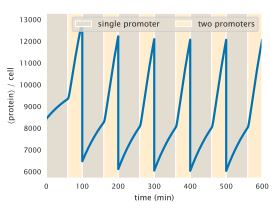

In [16]:
# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Plot mean protein as solid line
ax.plot(df_p_unreg.time / 60, p_mean, label='', lw=2.2)

# Group data frame by cell cycle
df_group = df_p_unreg.groupby('cycle')
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df['cycle'].max():
        label_s = 'single promoter'
        label_d = 'two promoters'
    else:
        label_s = ''
        label_d = ''
    # Find index for one-promoter state
    idx = np.where(data.state == 'single')[0]
    # Indicate states with two promoters
    ax.axvspan(data.iloc[idx.min()]['time'] / 60, data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    
    # Find index for two-promoter state
    idx = np.where(data.state == 'double')[0]
    # Indicate states with two promoters
    ax.axvspan(data.iloc[idx.min()]['time'] / 60, data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)

# Set limits
ax.set_xlim(df['time'].min() / 60, df['time'].max() / 60)
# Label plot
ax.set_xlabel('time (min)')
ax.set_ylabel(r'$\left\langle \right.$protein$\left. \right\rangle$ / cell')

ax.legend(loc='upper right', ncol=2)
plt.tight_layout()
plt.savefig(figdir + 'mean_protein_cycles.pdf', bbox_inches='tight')

For the protein case we can se that as expected the system does not reach the steady state for either of the two promoter copy numbers. What this means is that given the slower degradation rate of the protein the system doesn't have enough time to relax into the one- or two-promoter steady state.

But interestingly enough, the protein reaches some sort of "dynamic steady state" in which after several cell cycles the system reproducibly repeats the pattern of expression over and over again.

Let's plot both first moments side to side.

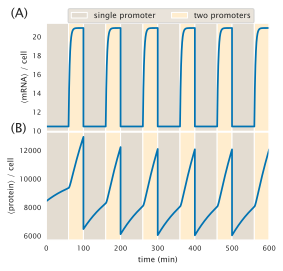

In [17]:
# Initialize figure
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)

# Plot mean mRNA as solid line
ax[0].plot(df_p_unreg.time / 60, m_mean, label='')
ax[1].plot(df_p_unreg.time / 60, p_mean, label='')

# Group data frame by cell cycle
df_group = df_p_unreg.groupby('cycle')

# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df['cycle'].max():
        label_s = 'single promoter'
        label_d = 'two promoters'
    else:
        label_s = ''
        label_d = ''
    # Find index for one-promoter state
    idx = np.where(data.state == 'single')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60, 
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60, 
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label='')
    
    # Find index for two-promoter state
    idx = np.where(data.state == 'double')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60,
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60,
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label='')

# Set limits
ax[0].set_xlim(df['time'].min() / 60, df['time'].max() / 60)
ax[1].set_xlim(df['time'].min() / 60, df['time'].max() / 60)

# Add letter label to subplots
plt.figtext(0.001, 0.9, '(A)', fontsize=13)
plt.figtext(0.001, 0.5, '(B)', fontsize=13)

# Label plot
ax[1].set_xlabel('time (min)')
ax[0].set_ylabel(r'$\left\langle \right.$mRNA$\left. \right\rangle$ / cell')
ax[1].set_ylabel(r'$\left\langle \right.$protein$\left. \right\rangle$ / cell')

# Set legend for both plots
ax[0].legend(loc='upper right', ncol=2, bbox_to_anchor=(0.95, 1.17))
plt.subplots_adjust(hspace=0.005)
plt.savefig(figdir + 'first_mom_cycles.pdf', bbox_inches='tight')

# Moment dynamics with cells exponentially distributed along cell cycle

As first discussed by Powell in 1956 populations of cells in a log-phase are exponentially distributed along the cell cycle. This distribution is of the form
$$
P(a) = (\ln 2) \cdot 2^{1 - a},
$$
where $a \in [0, 1]$ is the stage of the cell cycle, with $a = 0$ being the start of the cycle and $a = 1$ being the division.

Our numerical integration of the moment equations gave us a time evolution of
the moments along the cell cycle. Without loss of generality let's focus on the
first mRNA moment $\ee{m(t)}$ (the same can be applied to all other moments).
In order to calculate the first moment along the entire cell cycle we must
average each time point by the corresponding probability that a cell is found
in such time point. This translates to computing the integral
$$
  \ee{m} = \int_{\text{beginning cell cycle}}^{\text{end cell cycle}}
                       \ee{m(t)} P(t) dt.
$$

If we map each time point in the cell cycle into a fraction we can use
the distribution and compute instead
$$
  \ee{m} = \int_0^1 \ee{m(a)} P(a) da.
  \label{eq_moment_avg}
$$

In this section we will compare the simple repression thermodynamic model of gene expression with this dynamical picture of the cell cycle.

## Three-state promoter

Let's now include the regulation given by the repressor. For this we change to the three-state promoter that includes two new parameters $\kron$ and $\kroff$. At the mRNA level by assumption our parameter inference assumed that the promoter quickly relaxed from the steady state with one promoter to the steady state with two promoters. This is clearly reflected in the dynamics as we saw in the previous section. Therefore, if we ignore the transients between the single promoter and the two promoters state, the fold-change is of the form. 
$$
\foldchange = 
{ f \cdot \ee{m(R \neq 0)}_1 + (1 - f) \cdot \ee{m(R \neq 0)}_2
\over
f \cdot \ee{m(R = 0)}_1 + (1 - f) \cdot \ee{m(R = 0)}_2},
$$
where $f \in [0, 1]$ is the fraction of the cell cycle that cells spend with a single copy of the promoter.

Just as our reporter gene changes in copy number and therefore the protein copy number changes along the cell cycle we expect the repressor copy number itself to vary as cells grow and divide. We simplify this picture and assume that the experimentally determined repressor copy number is an effective parameter that remains unchanged along the cell cycle. What that means for our model is that $\kron$ doesn't change along the cell cycle. This is obviously an approximation and only the numerical test of this assumption will tell us how much it affects the theoretical predictions. Under this assumption it can be shown that the fold-change can be simplified to
$$
\foldchange = \left( 1 + {\kron \over \kroff} \left( {\kpon \over \kpon + \kpoff} \right) \right)^{-1}.
$$
We can then use the fact that the functional form is exactly the same as the thermodynamic fold-change to constraint the value of the $\kron \over \kroff$ ratio.

Working with this let's compute the fold-change using this kinetic model.

First we need to define the parameters for the regulated promoter.

In [8]:
# Define repressor specific parameters

# Diffusion limited rate
ko = 2.7E-3 # s**-1 nmol**-1

# Number of non-specific binding sites in thermodynamic model
Nns = 4.6E6

# Cell volume
Vcell = 2.15 # fL

# MWC induction parameters
ka = 139 # µM
ki = 0.53 # µM
epsilon = 4.5 # kBT

### LacI titration

To compare the results from the kinetic and the equilibrium model we need to compute the mRNA and protein first moment averaged over the entire cell cycle. We will do this by performing the integral explained in the previous section.

In [19]:
# Extract index for mRNA and protein first moment
first_mom_names_m = [x for x in df.columns if 'm1p0' in x]
first_mom_names_p = [x for x in df.columns if 'm0p1' in x]

# Extract the last cycle information
df_m_unreg_first = df_p_unreg.loc[df_p_unreg.cycle == df_p_unreg.cycle.max(),
                                  first_mom_names_m]
df_p_unreg_first = df_p_unreg.loc[df_p_unreg.cycle == df_p_unreg.cycle.max(),
                                  first_mom_names_p]

# Define array for integration
a_array = np.linspace(0, 1, len(df_m_unreg_first))
# Compute probability based on this array
p_a_array = np.log(2) * 2**(1 - a_array)

# Perform numerical integration
m_mean_unreg = sp.integrate.simps(df_m_unreg_first.sum(axis=1) * p_a_array,
                                  a_array)
p_mean_unreg = sp.integrate.simps(df_p_unreg_first.sum(axis=1) * p_a_array,
                                  a_array)

print('<m> = {:.2f}'.format(m_mean_unreg))
print('<p> = {:.2f}'.format(p_mean_unreg))

<m> = 14.42
<p> = 8257.82


We will define the mRNA production matrix $\mathbf{R}_m$, the mRNA degradation matrix $\mathbf{\Gamma}_m$, the protein production matrix $\mathbf{R}_p$, and the protein degradation matrix $\mathbf{\Gamma}_p$ for the three-state promoter since these matrices does not depend on the repressor copy number or the binding site.

In [20]:
# Define the production matrix
Rm_reg = np.array([[rm, 0, 0],
                   [0, 0, 0],
                   [0, 0, 0]])
# Define the degradation matrix
Gm_reg = np.array([[gm, 0, 0],
                   [0, gm, 0],
                   [0, 0, gm]])

# Define the production matrix
Rp_reg = np.array([[rp, 0, 0],
                   [0, rp, 0],
                   [0, 0, rp]])

# Define the production matrix
Gp_reg = np.array([[gp, 0, 0],
                   [0, gp, 0],
                   [0, 0, gp]])

Now let's compute the fold-change for different operators and different repressor copy numbers updating the state transition matrix $\Km$ at each iteration.

In [21]:
# Define repressor copy number list
rep_array = [22, 60, 124, 260, 1220, 1740] # repressors per cell

# Define energies
operators = ['O1', 'O2', 'O3']
energies = [-15.3, -13.9, -9.7]

# Initialize data frame to save fold-changes
names = ['operator', 'energy', 'repressors',
         'mean_m_reg', 'mean_m_unreg', 'fold_change_m',
         'mean_p_reg', 'mean_p_unreg', 'fold_change_p']
df_fc_p = pd.DataFrame(columns=names)

# Loop through operators
for j, en in enumerate(energies):
    # Define binding energy
    eRA = en
    # Loop through repressor copy numbers
    for i, rep in enumerate(rep_array):
        # Calculate the repressor on rate including the MWC model
        kr_on = ko * rep * chann_cap.p_act(0, ka, ki, epsilon) 

        # Compute the repressor off-rate based on the on-rate and 
        # the binding energy
        kr_off = chann_cap.kr_off_fun(eRA, ko, kp_on, kp_off, Nns, Vcell)

        # Define the rate constant matrix
        Km_reg = np.array([[-kp_off, kp_on, 0], 
                           [kp_off, -(kp_on + kr_on), kr_off],
                           [0, kr_on, -kr_off]])

        # Define initial conditions
        m0_init = [0.3, 0.3, 0.4]
        m1_init = [0, 0, 0]
        m2_init = [0, 0, 0]
        m3_init = [0, 0, 0]
        p1_init = [0, 0, 0]
        mp_init = [0, 0, 0]
        p2_init = [0, 0, 0]
        m2p_init = [0, 0, 0]
        mp2_init = [0, 0, 0]
        p3_init = [0, 0, 0]

        # Numerically integrate equations
        m_init = sp.integrate.odeint(dpdt, 
                                     m0_init + m1_init + m2_init + m3_init +
                                     p1_init + mp_init + p2_init + m2p_init +
                                     mp2_init + p3_init,
                                     t, 
                                     args=(Km_reg, Rm_reg, Gm_reg,
                                           Rp_reg, Gp_reg))
        # Keep last time point as initial condition
        m_init = m_init[-1, :]

        # Integrate moment equations
        df = dpdt_cycles(m_init, t_single, t_double, n_cycles,
                         Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg,
                         states=['P', 'E', 'R'], n_steps=300)

        # Keep only last cycle
        df = df[df['cycle'] == df['cycle'].max()]

        # Extract index for mRNA and protein first moment
        first_mom_names_m = [x for x in df.columns if 'm1p0' in x]
        first_mom_names_p = [x for x in df.columns if 'm0p1' in x]

        # Extract the last cycle information of the first moments
        df_m_reg_first = df.loc[:, first_mom_names_m]
        df_p_reg_first = df.loc[:, first_mom_names_p]

        # Define array for integration
        a_array = np.linspace(0, 1, len(df_m_reg_first))
        # Compute probability based on this array
        p_a_array = np.log(2) * 2**(1 - a_array)

        # Perform numerical integration
        m_mean_reg = sp.integrate.simps(df_m_reg_first.sum(axis=1) * p_a_array,
                                          a_array)
        p_mean_reg = sp.integrate.simps(df_p_reg_first.sum(axis=1) * p_a_array,
                                          a_array)

        # Compute the fold-change
        fold_change_m = m_mean_reg / m_mean_unreg
        fold_change_p = p_mean_reg / p_mean_unreg
        
        # Save results into series in order to append it to data frame
        series = pd.Series([operators[j], energies[j], rep, 
                            m_mean_reg, m_mean_unreg, fold_change_m,
                            p_mean_reg, p_mean_unreg, fold_change_p],
                           index=names)
        
        df_fc_p = df_fc_p.append(series, ignore_index=True)

Let't take a look at the dataframe

In [22]:
df_fc_p.head()

operator  energy repressors  mean_m_reg  mean_m_unreg  fold_change_m  \
0       O1   -15.3         22    0.514269     14.419276       0.035665   
1       O1   -15.3         60    0.192925     14.419276       0.013380   
2       O1   -15.3        124    0.094000     14.419276       0.006519   
3       O1   -15.3        260    0.044984     14.419276       0.003120   
4       O1   -15.3       1220    0.009610     14.419276       0.000667   

   mean_p_reg  mean_p_unreg  fold_change_p  
0  294.647911   8257.819379       0.035681  
1  110.535918   8257.819379       0.013386  
2   53.857465   8257.819379       0.006522  
3   25.774040   8257.819379       0.003121  
4    5.506712   8257.819379       0.000667

We can visualize these results by ploting the fold-change in gene expression as a function of repressor copy number in a log-log plot.

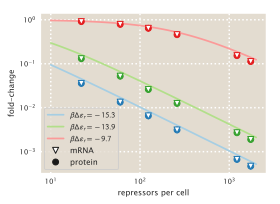

In [23]:
# Define range of repressors for which compute the thermo fold-change
r_array = np.logspace(1, np.log10(2000), 50)

# Group data frame by operator
df_group = df_fc_p.groupby('energy')

# Define colors
colors = sns.color_palette('Paired', n_colors=len(df_group) * 2)

# Initialize figure
fig = plt.figure(figsize=(4, 3))
# Loop through operator
for i, (group, data) in enumerate(df_group):
    # Compute thermo fold-change
    fold_change_thermo = (1 + r_array / Nns * np.exp(- group))**-1

    # Plot thermodynamic fold-change prediction
    plt.plot(r_array, fold_change_thermo,
             label=r'$\beta\Delta\epsilon_r = {:.1f}$'.format(data.energy.unique()[0]),
             color=colors[i * 2])
    # Plot the kinetic fold-change prediciton
    # Protein
    plt.plot(data.repressors.values, data.fold_change_p.values, lw=0, marker='o', 
             color=colors[(i * 2) + 1], label='')
    # mRNA
    plt.plot(data.repressors.values, data.fold_change_m.values, lw=0, marker='v', 
             markeredgecolor=colors[(i * 2) + 1], markeredgewidth=1,
             markerfacecolor='w', label='')

# Generate labels for mRNA and protein
plt.plot([], [], lw=0, marker='v', 
         markeredgecolor='k', markeredgewidth=1,
         markerfacecolor='w', label='mRNA')
plt.plot([], [], lw=0, marker='o', 
         color='k', label='protein')

# Change scale to log
plt.xscale('log')
plt.yscale('log')

# Label axis
plt.xlabel('repressors per cell')
plt.ylabel('fold-change')

# Set legend
plt.legend()

# Save figure
plt.tight_layout()
plt.savefig(figdir + 'lacI_titration.pdf', bbox_inches='tight')

The small deviations between the kinetic and the thermodynamic picture come from the fact that the parameters as determined assume that the mRNA reaches steady state for both the single- and the double-promoter state, ignoring the changes in repressor copy number as the cell cycle progresses for example. But these deviations are within our experimental resolution, so the approximation seems to do a good job.

### IPTG titration 

Now that we know that the rates are able to reproduce the equilibrium picture of the LacI titration (up to a systematic deviation) let's complete the analysis of the equivalence between both frameworks by including the effect of the inducer.

For this analysis we will keep the operator fix and vary both the repressor copy number and the IPTG concentration.

Let's run the dynamics for several cell cycles while varying the inducer concentration.

In [26]:
# repressor-DNA binding energy
op = 'O2'
eRA = -13.9 # kBT

# Define repressor copy number list
rep_array = [22, 60, 124, 260, 1220, 1740] # repressors per cell

# Define IPTG concentrations
iptg_array = [0, 0.1, 5, 10, 25, 50, 75, 100, 500, 1000] # µM

# Initialize data frame to save fold-changes
names = ['operator', 'energy', 'repressors', 'iptg_uM',
         'mean_m_reg', 'mean_m_unreg', 'fold_change_m',
         'mean_p_reg', 'mean_p_unreg', 'fold_change_p']
df_fc_iptg = pd.DataFrame(columns=names)

# Loop through operators
for j, iptg in enumerate(iptg_array):
    print(iptg)
    # Loop through repressor copy numbers
    for i, rep in enumerate(rep_array):
        # Calculate the repressor on rate including the MWC model
        kr_on = ko * rep * chann_cap.p_act(iptg, ka, ki, epsilon) 

        # Compute the repressor off-rate based on the on-rate and 
        # the binding energy
        kr_off = chann_cap.kr_off_fun(eRA, ko, kp_on, kp_off, Nns, Vcell)

        # Define the rate constant matrix
        Km_reg = np.array([[-kp_off, kp_on, 0], 
                           [kp_off, -(kp_on + kr_on), kr_off],
                           [0, kr_on, -kr_off]])

        # Define initial conditions
        m0_init = [0.3, 0.3, 0.4]
        m1_init = [0, 0, 0]
        m2_init = [0, 0, 0]
        m3_init = [0, 0, 0]
        p1_init = [0, 0, 0]
        mp_init = [0, 0, 0]
        p2_init = [0, 0, 0]
        m2p_init = [0, 0, 0]
        mp2_init = [0, 0, 0]
        p3_init = [0, 0, 0]

        # Numerically integrate equations
        m_init = sp.integrate.odeint(dpdt, 
                                     m0_init + m1_init + m2_init + m3_init +
                                     p1_init + mp_init + p2_init + m2p_init +
                                     mp2_init + p3_init,
                                     t, 
                                     args=(Km_reg, Rm_reg, Gm_reg,
                                           Rp_reg, Gp_reg))
        # Keep last time point as initial condition
        m_init = m_init[-1, :]

        # Integrate moment equations
        df = dpdt_cycles(m_init, t_single, t_double, n_cycles,
                         Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg,
                         states=['P', 'E', 'R'])

        # Keep only last cycle
        df = df[df['cycle'] == df['cycle'].max()]

        # Extract index for first moment
        first_mom_names_m = [x for x in df.columns if 'm1p0' in x]
        first_mom_names_p = [x for x in df.columns if 'm0p1' in x]

        # Extract the last cycle information of the first moments
        df_m_reg_first = df.loc[:, first_mom_names_m]
        df_p_reg_first = df.loc[:, first_mom_names_p]
        
        # Define array for integration
        a_array = np.linspace(0, 1, len(df_m_reg_first))
        # Compute probability based on this array
        p_a_array = np.log(2) * 2**(1 - a_array)

        # Perform numerical integration
        m_mean_reg = sp.integrate.simps(df_m_reg_first.sum(axis=1) * p_a_array,
                                          a_array)
        p_mean_reg = sp.integrate.simps(df_p_reg_first.sum(axis=1) * p_a_array,
                                          a_array)

        # Compute the fold-change
        fold_change_m = m_mean_reg / m_mean_unreg
        fold_change_p = p_mean_reg / p_mean_unreg
        
        # Save results into series in order to append it to data frame
        series = pd.Series([op, eRA, rep, iptg,
                            m_mean, m_mean_unreg, fold_change_m,
                            p_mean, p_mean_unreg, fold_change_p],
                           index=names)
        
        df_fc_iptg = df_fc_iptg.append(series, ignore_index=True)

0
0.1
5
10
25
50
75
100
500
1000


Let's plot the inducer titration to compare the predictions done by the equilibrium picture and the kinetic model with this new variation.

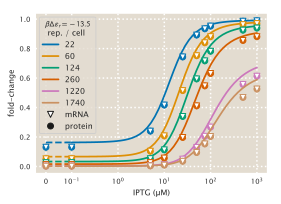

In [41]:
# Define IPTG range to compute thermodynamic fold-change
iptg = np.logspace(-1, 3, 50)
iptg_lin = [0, 0.1]

# Group data frame by repressor copy number
df_group = df_fc_iptg.groupby('repressors')

# Define colors
colors = sns.color_palette('colorblind', n_colors=len(df_group))

# Initialize figure
fig = plt.figure(figsize=(4, 3))
# Loop through each of the repressor copy numbers
for i, (rep, data) in enumerate(df_group):
    # Compute thermodynamic fold-change
    fc_thermo = (1 + rep / Nns * chann_cap.p_act(iptg, ka, ki, epsilon) *
                 np.exp(- data.energy.unique()[0]))**-1
    fc_thermo_lin = (1 + rep / Nns * chann_cap.p_act(iptg_lin, ka, ki, epsilon) *
                 np.exp(- data.energy.unique()[0]))**-1
    
    # Plot thermodynamic fold-change prediction
    plt.plot(iptg, fc_thermo, label=str(rep), color=colors[i])
    plt.plot(iptg_lin, fc_thermo_lin, label='', color=colors[i],
             linestyle='--')
    
    # Plot the kinetic fold-change prediciton
    # Protein
    plt.plot(data.iptg_uM.values, data.fold_change_p.values, lw=0, marker='o', 
             color=colors[i], label='')
    # mRNA
    plt.plot(data.iptg_uM.values, data.fold_change_m.values, lw=0, marker='v', 
             markeredgecolor=colors[i], markeredgewidth=1,
             markerfacecolor='w', label='')

# Generate labels for mRNA and protein
plt.plot([], [], lw=0, marker='v', 
         markeredgecolor='k', markeredgewidth=1,
         markerfacecolor='w', label='mRNA')
plt.plot([], [], lw=0, marker='o', 
         color='k', label='protein')
    
# Change scale to log
plt.xscale('symlog', linthreshx=1E-1, linscalex=0.5)

# Label axis
plt.xlabel('IPTG (µM)')
plt.ylabel('fold-change')

# Set legend
legend = plt.legend(title=r'$\beta\Delta\epsilon_r =  -13.5$' '\n rep. / cell')
plt.setp(legend.get_title(),fontsize=8)

# Save figure
plt.tight_layout()
plt.savefig(figdir + 'IPTG_titration.pdf', bbox_inches='tight')

## Systematic moment computation

Now that we confirmed that these parameters can reproduce the equilibrium picture let's systematically obtain average moments for varying repressor copy numbers, operators and inducer concentrations that later on we will use to compute the maximum entropy approximation of the distribution.

We will generate and export a tidy data frame containing all moments.

Let's now list the parameters that will be varied for the different strains.

In [42]:
# Define experimental concentrations in µM
inducer = [0, 0.1, 5, 10, 25, 50, 75, 100, 250, 500, 1000, 5000] # µM

# Define repressor copy numebers
repressors = np.logspace(0, np.log10(2000), 30)
repressors = np.unique(repressors.round(0))

# Include repressor copy numbers for experimentally available strains
rep = [0, 22, 60, 124, 260, 1220, 1740]
# Include repressor dimers into the list
rep = rep + [r / 2 for r in rep[1:]]
# Add them to list
repressors =  np.sort(np.concatenate([repressors, rep]))

# Define operators and energies
operators = ['O1', 'O2', 'O3']
energies = [-15.3, -13.9, -9.7]
op_dict = dict(zip(operators, energies))

# Generate list of all operator, repressor and inducer concentrations
var =  [t for t in itertools.product(*[operators, repressors, inducer])]

Now given these parameters let's integrate the moment equations and then compute the average moment over the cell cycle as we have done so far for the first moment.

In [9]:
# Define index of moments to be used in the computation
moments = [(1, 0), (2, 0), (3, 0),
           (0, 1), (1, 1), (0, 2),
           (2, 1), (1, 2), (0, 3)]

# Initialize data frame to save the lagrange multipliers.
names = ['operator', 'binding_energy', 'repressor', 'inducer_uM']
names = names + ['m' + str(m[0]) + 'p' + str(m[1]) for m in moments]         

# Initialize DataFrame to save constraints
df_constraints = pd.DataFrame([], columns=names)

compute_constraints = False
if compute_constraints:
    # Define function for parallel computation
    def constraints_parallel(param):
        # Extract variables
        op = param[0]  #operator
        eRA = op_dict[op]  # binding energy
        rep = param[1]  # repressors
        iptg = param[2]  # inducer
        
        # Calculate the repressor on rate including the MWC model
        kr_on = ko * rep * chann_cap.p_act(iptg, ka, ki, epsilon) 

        # Compute the repressor off-rate based on the on-rate and 
        # the binding energy
        kr_off = chann_cap.kr_off_fun(eRA, ko, kp_on, kp_off, Nns, Vcell)

        # Define the rate constant matrix
        Km_reg = np.array([[-kp_off, kp_on, 0], 
                           [kp_off, -(kp_on + kr_on), kr_off],
                           [0, kr_on, -kr_off]])

        # Define initial conditions
        m0_init = [0.3, 0.3, 0.4]
        m1_init = [0, 0, 0]
        m2_init = [0, 0, 0]
        m3_init = [0, 0, 0]
        p1_init = [0, 0, 0]
        mp_init = [0, 0, 0]
        p2_init = [0, 0, 0]
        m2p_init = [0, 0, 0]
        mp2_init = [0, 0, 0]
        p3_init = [0, 0, 0]

        # Define time on which to perform integration
        t = np.linspace(0, 100 * 60, 301)
        # Numerically integrate equations
        m_init = sp.integrate.odeint(dpdt, 
                                     m0_init + m1_init + m2_init + m3_init +
                                     p1_init + mp_init + p2_init + m2p_init +
                                     mp2_init + p3_init,
                                     t, 
                                     args=(Km_reg, Rm_reg, Gm_reg,
                                           Rp_reg, Gp_reg))
        # Keep last time point as initial condition
        m_init = m_init[-1, :]

        # Integrate moment equations
        df = dpdt_cycles(m_init, t_single, t_double, n_cycles,
                         Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg,
                         n_steps=300,
                         states=['P', 'E', 'R'])

        # Keep only last cycle
        df = df[df['cycle'] == df['cycle'].max()]

        # Define array for integration
        a_array = np.linspace(0, 1, len(df))
        # Compute probability based on this array
        p_a_array = np.log(2) * 2**(1 - a_array)

        # Initialize list to append moments
        moms = list()
        # Loop through moments computing the average moment
        for i, mom in enumerate(moments):
            # Generate string that finds the moment
            mom_name = 'm' + str(mom[0]) + 'p' + str(mom[1])
            # List rows with moment
            mom_bool = [x for x in df.columns if mom_name in x]
            # Extract data for this particular moment
            df_mom = df.loc[:, mom_bool].sum(axis=1)

            # Average moment and append it to list
            moms.append(sp.integrate.simps(df_mom * p_a_array,
                                           a_array))
                
        # Save results into series in order to append it to data frame
        series = pd.Series([op, eRA, rep, iptg] + moms,
                   index=names)
    
        return series
    
    # Run function in parallel
    constraint_series = Parallel(n_jobs=6)(delayed(constraints_parallel)(param)
                           for param in var)

    # Initialize data frame to save list of parameters
    df_constraints = pd.DataFrame([], columns=names)

    for s in constraint_series:
        df_constraints = df_constraints.append(s, ignore_index=True)

    # Save progress at each step
    df_constraints.to_csv(datadir + 'MaxEnt_multi_promoter_cell_division_expo_dist_100min_constraints.csv',
              index=False)

df_constraints = pd.read_csv(datadir + 'MaxEnt_multi_promoter_cell_division_expo_dist_100min_constraints.csv')
df_constraints.head()

operator  binding_energy  repressor  inducer_uM       m1p0       m2p0  \
0       O1           -15.3        0.0         0.0  14.411945  281.16823   
1       O1           -15.3        0.0         0.1  14.411945  281.16823   
2       O1           -15.3        0.0         5.0  14.411945  281.16823   
3       O1           -15.3        0.0        10.0  14.411945  281.16823   
4       O1           -15.3        0.0        25.0  14.411945  281.16823   

          m3p0         m0p1           m1p1          m0p2          m2p1  \
0  6919.633836  8256.945872  127700.332069  8.586756e+07  2.643869e+06   
1  6919.633836  8256.945872  127700.332069  8.586756e+07  2.643869e+06   
2  6919.633836  8256.945872  127700.332069  8.586756e+07  2.643869e+06   
3  6919.633836  8256.945872  127700.332069  8.586756e+07  2.643869e+06   
4  6919.633836  8256.945872  127700.332069  8.586756e+07  2.643869e+06   

           m1p2          m0p3  
0  1.362401e+09  9.668466e+11  
1  1.362401e+09  9.668466e+11  
2  1.362401e+09  9.668466e+11  
3  1.362401e+09  9.668466e+11  
4  1.362401e+09  9.668466e+11

### Comparing constraints with single-promoter model.

An interesting question is how we expect the moments to change with respect to a kinetic model in which the variability in gene copy number along the cell cycle is ignored.

The first interesting quantity to compare will be the first moments of mRNA and protein. We expect these to be quite similar, with different numerical values, but similar qualitative behavior.

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


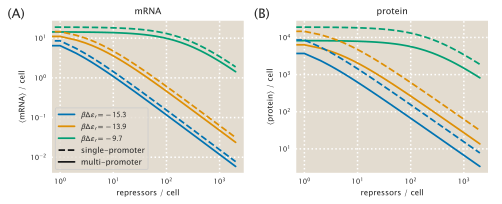

In [10]:
# Load moments for multi-promoter level
df_constraints = pd.read_csv(datadir + 'MaxEnt_multi_promoter_cell_division_expo_dist_100min_constraints.csv')

# Read constraints for the single promoter model
df_constraints_single = pd.read_csv(datadir +
                                    'MaxEnt_ss_constraints.csv')
# Remove Oid
df_constraints_single = df_constraints_single\
                        [df_constraints_single.operator != 'Oid']

# Group both by binding energy
df_group = df_constraints.sort_values('repressor')\
          [df_constraints.inducer_uM == 0].groupby('binding_energy')
df_single_group = df_constraints_single.sort_values('repressor')\
          [df_constraints_single.inducer_uM == 0].groupby('binding_energy')

# Define colors for plot
colors = sns.color_palette('colorblind', n_colors=len(df_group))

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharey=False, sharex=True)

# Loop through the groups and plot protein first moment
for i, (group, data) in enumerate(df_group):
    ax[0].plot(data.repressor, data.m1p0, 
               label=r'$\beta\Delta\epsilon_r = {:.1f}$'.format(group), color=colors[i])
    ax[1].plot(data.repressor, data.m0p1, label=group, color=colors[i])

    
for i, (group, data) in enumerate(df_single_group):
    ax[0].plot(data.repressor, data.m1p0, color=colors[i],
             linestyle='--', label='')
    ax[1].plot(data.repressor, data.m0p1, color=colors[i],
             linestyle='--', label='')

# Generate legend for single vs double promoter
ax[0].plot([], [], color='k', linestyle='--', label='single-promoter')
ax[0].plot([], [], color='k', label='multi-promoter')

# Change plot scale
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

# Label axis
ax[0].set_xlabel('repressors / cell')
ax[1].set_xlabel('repressors / cell')
ax[0].set_ylabel(r'$\left\langle \right.$mRNA$\left. \right\rangle$ / cell')
ax[1].set_ylabel(r'$\left\langle \right.$protein$\left. \right\rangle$ / cell')

# Set title
ax[0].set_title('mRNA')
ax[1].set_title('protein')

# Include legend
ax[0].legend()

# Add letter label to subplots
plt.figtext(0.01, 0.9, '(A)', fontsize=13)
plt.figtext(0.5, 0.9, '(B)', fontsize=13)

# Save figure
plt.tight_layout()
plt.savefig(figdir + 'first_mom_comparison.pdf', bbox_inches='tight')

As expected the mRNA first moment are basically the same since given the fast degradation rate this molecule is basically at steady state for the most part during both phases in the multi-promoter case. For the protein we have that the multi promoter model has systematically less protein than the single promoter case. This is because since protein never reaches the steady state for the two-promoter case it doesn't have as much as one would expect from the steady state assumption.

#### Noise $\eta$

Let's now look at the noise $\eta$ defined as
$$
\eta \equiv {\text{STD}(X) \over \ee{X}},
$$
where $\text{STD}(x)$ is the standard deviation of the random variable $X$. The reason for choosing this metric over the commonly used Fano factor is that when quantified from experimental data this is a dimensionless quantity that can be directly inferred from arbitrary units of fluorescence as long as there is a linear relationship between these arbitrary units and the absolute molecule count.

The expectation here is that since having multiple promoters increases the variability over the cell cycle, the multi-promoter model should have a higher noise.

Let's first compute this quantity for both the mRNA and protein level

In [11]:
# Compute the noise for the single-promoter data
df_constraints_single = df_constraints_single.assign(m_noise=np.sqrt(df_constraints_single.m2p0 - 
                                                                     df_constraints_single.m1p0**2) / 
                                                     df_constraints_single.m1p0,
                               p_noise=np.sqrt(df_constraints_single.m0p2 - df_constraints_single.m0p1**2) / 
                                                     df_constraints_single.m0p1)

# Compute the noise for the multi-promoter data
df_constraints = df_constraints.assign(m_noise=np.sqrt(df_constraints.m2p0 -  df_constraints.m1p0**2) / 
                                                     df_constraints.m1p0,
                               p_noise=np.sqrt(df_constraints.m0p2 - df_constraints.m0p1**2) / 
                                                     df_constraints.m0p1)

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


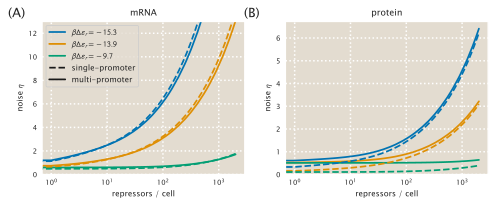

In [12]:
# Group both
df_group = df_constraints.sort_values('repressor')\
          [df_constraints.inducer_uM == 0].groupby('binding_energy')
df_single_group = df_constraints_single.sort_values('repressor')\
          [df_constraints_single.inducer_uM == 0].groupby('binding_energy')

# Define colors for plot
colors = sns.color_palette('colorblind', n_colors=len(df_group))

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharey=False, sharex=True)

# Loop through the groups and plot protein first moment
for i, (group, data) in enumerate(df_group):
    ax[0].plot(data.repressor, data.m_noise, 
               label=r'$\beta\Delta\epsilon_r = {:.1f}$'.format(group), color=colors[i])
    ax[1].plot(data.repressor, data.p_noise, 
               label=r'$\beta\Delta\epsilon_r = {:.1f}$'.format(group), color=colors[i])

    
for i, (group, data) in enumerate(df_single_group):
    ax[0].plot(data.repressor, data.m_noise, color=colors[i],
             linestyle='--', label='')
    ax[1].plot(data.repressor, data.p_noise, color=colors[i],
             linestyle='--', label='')

# Generate legend for single vs double promoter
ax[0].plot([], [], color='k', linestyle='--', label='single-promoter')
ax[0].plot([], [], color='k', label='multi-promoter')

# Change plot scale
ax[0].set_xscale('log')
ax[1].set_xscale('log')

# Set plot so that it shows where 0 in the y-axis is
ax[0].set_ylim(bottom=0, top=13)
ax[1].set_ylim(bottom=0)

# Label axis
ax[0].set_xlabel('repressors / cell')
ax[1].set_xlabel('repressors / cell')
ax[0].set_ylabel(r'noise $\eta$')
ax[1].set_ylabel(r'noise $\eta$')

# Set title
ax[0].set_title('mRNA')
ax[1].set_title('protein')

# Include legend
ax[0].legend()

# Add letter label to subplots
plt.figtext(0.01, 0.91, '(A)', fontsize=13)
plt.figtext(0.48, 0.91, '(B)', fontsize=13)

# Save figure
plt.tight_layout()
plt.savefig(figdir + 'noise_comparison.pdf', bbox_inches='tight')

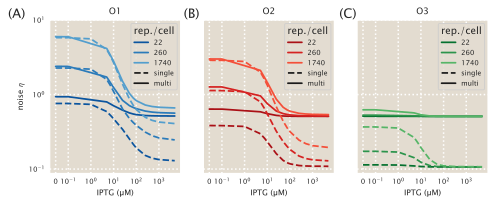

In [13]:
# Define repressor copy numbers to include
rep = [22, 260, 1740]

# Group moments by operator and repressor
df_group = df_constraints[df_constraints['repressor'].isin(rep)].\
           sort_values('inducer_uM').\
           groupby(['operator', 'repressor'])
df_group_single = df_constraints_single[df_constraints_single['repressor'].isin(rep)].\
                  sort_values('inducer_uM').\
                  groupby(['operator', 'repressor'])

# Generate index for each opeartor
operators = ['O1', 'O2', 'O3']
op_idx = dict(zip(operators, np.arange(3)))

# Generate list of colors
col_list = ['Blues_r', 'Reds_r', 'Greens_r']
# Loop through operators generating dictionary of colors for each
col_dict = {}
for i, op in enumerate(operators):
    col_dict[op] = dict(zip(rep, sns.color_palette(col_list[i], n_colors=len(rep) + 3)[0:3]))

# Initialize figure
fig, ax = plt.subplots(1, 3, figsize=(7, 3), sharex=True, sharey=True)

# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    ax[op_idx[group[0]]].plot(data.inducer_uM, data.p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))

# Loop through groups on single-promoter
for i, (group, data) in enumerate(df_group_single):
    ax[op_idx[group[0]]].plot(data.inducer_uM, data.p_noise, linestyle='--',
                              color=col_dict[group[0]][group[1]],
                              label='')


for i, a in enumerate(ax):
    # Generate legend for single vs double promoter
    ax[i].plot([], [], color='k', linestyle='--', label='single')
    ax[i].plot([], [], color='k', label='multi')
    # systematically change axis for all subplots
    ax[i].set_xscale('symlog', linthreshx=1E-1, linscalex=0.5)
    ax[i].set_yscale('log')
    ax[i].set_ylim(top=10)
    # Set legend
    ax[i].legend(title='rep./cell', fontsize=7)
 
    # Set title
    ax[i].set_title(operators[i])
    # Label axis
    ax[i].set_xlabel(r'IPTG (µM)')
ax[0].set_ylabel(r'noise $\eta$')

# Label plots with letters
plt.figtext(0.01, 0.9, '(A)', fontsize=13)
plt.figtext(0.36, 0.9, '(B)', fontsize=13)
plt.figtext(0.67, 0.9, '(C)', fontsize=13)
   
plt.tight_layout()
plt.savefig(figdir + 'noise_comparison.pdf', bbox_inches='tight')

## Comparison with experimental data

In order to asses if our dynamical theory for the moments works we will compare experimentally determined moments to our theoretical predictions.

For this we need to read the microscopy data gathered so far.

In [50]:
# Read the tidy-data frame
# mwc_files = glob.glob('../../data/csv_microscopy/mwc_data/*csv')
files = glob.glob('../../data/csv_microscopy/*IPTG*csv')# + mwc_files
df_micro = pd.concat(pd.read_csv(f, comment='#') for f in files if 'Oid' not in f)

##  Remove data sets that are ignored because of problems with the data quality
##  NOTE: These data sets are kept in the repository for transparency, but they
##  failed at one of our quality criteria (see README.txt file in microscopy folder)
ignore_files = [x for x in os.listdir('../image_analysis/ignore_datasets/')
                if 'microscopy' in x]
# Extract data from these files
ignore_dates = [int(x.split('_')[0]) for x in ignore_files]

# Remove these dates
df_micro = df_micro[~df_micro['date'].isin(ignore_dates)]

# Include the absolute intensity measurement
df_micro.loc[:, 'intensity'] = df_micro['area'] * df_micro['mean_intensity']

df_micro[['date', 'operator', 'rbs', 'mean_intensity', 'intensity']].head()

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


date operator   rbs  mean_intensity   intensity
0  20161204       O3  auto       52.562979  137.252451
1  20161204       O3  auto       53.070565  142.653678
2  20161204       O3  auto       52.323744  221.015495
3  20161204       O3  auto       51.013142  174.995484
4  20161204       O3  auto       44.325267  166.804845

Consider that the noise is defined as
\begin{equation}
\eta \equiv \frac{\sqrt{\left\langle p^2 \right\rangle - \left\langle p \right\rangle^2}}{\left\langle p \right\rangle}.
\end{equation}
Assume that the intensity level of a cell $I$ is linearly proportional to the absolute protein count, i.e.
$$
I = \alpha p,
$$
where $\alpha$ is the proportionality constant between arbitrary units (a.u.) and protein count. Substituting this definition on the noise gives
\begin{equation}
\eta = {\sqrt{\left\langle (\alpha I)^2 \right\rangle - 
                   \left\langle \alpha I \right\rangle^2} \over 
                   \left\langle \alpha I \right\rangle}.
\end{equation}
Since $\alpha$ is a constant it can be taken out of the average operator $\ee{\cdot}$, obtaining
\begin{equation}
\eta = {\sqrt{\alpha^2 \left(\left\langle I^2 \right\rangle - 
              \left\langle I \right\rangle^2 \right)} \over 
              \alpha \left\langle  I \right\rangle}
     = {\sqrt{\left(\left\langle I^2 \right\rangle - 
              \left\langle I \right\rangle^2 \right)} \over 
              \left\langle  I \right\rangle}
\end{equation}

The proportionality between intensity and protein count has no intercept. This ignores the autofluorescence that cells without
reporter would generate. Therefore in practice to compute the noise from experimental intensity measurements we compute
\begin{equation}
\eta = \frac{\sqrt{\left\langle (I  - \langle I_{\text{auto}}\rangle)^2 \right\rangle - \left\langle (I  - \langle I_{\text{auto}}\rangle) \right\rangle^2}}{\left\langle (I  - \langle I_{\text{auto}}\rangle) \right\rangle},
\end{equation}
where $I$ is the intensity of the objective strain and $\langle I_{\text{auto}}\rangle$ is the mean autofluorescence intensity.

Having shown that this quantity is dimensionless we can therefore compare the experimentally determined noise with our theoretical predictions. Let's begin with the unregulated promoter.

### Unregulated promoter

Let's first take the intensity measurements of the $\Delta lacI$ strains and compute the noise.

In [51]:
# group by date and by IPTG concentration
df_group = df_micro.groupby(['date'])

# Define names for columns in data frame
names = ['date', 'IPTG_uM','operator', 'binding_energy',
        'rbs', 'repressors', 'mean', 'std', 'noise']

# Initialize data frame to save the noise
df_noise_delta = pd.DataFrame(columns=names)
for date, data in df_group:
    # Extract the mean autofluorescence
    I_auto = data[data.rbs == 'auto'].intensity.mean()
    
    # Extract the strain fluorescence measurements
    strain_data = data[data.rbs == 'delta']
    
    # Group data by IPTG measurement
    data_group = strain_data.groupby('IPTG_uM')
    for inducer, data_inducer in data_group:
        # Append the require info
        strain_info = [date, inducer, data_inducer.operator.unique()[0],
                       data_inducer.binding_energy.unique()[0],
                       data_inducer.rbs.unique()[0],
                       data_inducer.repressors.unique()[0],
                      (data_inducer.intensity - I_auto).mean(), 
                      (data_inducer.intensity - I_auto).std(ddof=1)]
        # Compute the noise
        strain_info.append(strain_info[-1] / strain_info[-2])
        # Convert to a pandas series to attach to the dataframe
        strain_info = pd.Series(strain_info, index=names)
        # Append to the info to the data frame
        df_noise_delta = df_noise_delta.append(strain_info, ignore_index=True)
    
df_noise_delta.head()

date  IPTG_uM operator  binding_energy    rbs repressors          mean  \
0  20161203      0.0       O2           -13.9  delta          0  18001.490853   
1  20161204      0.0       O3            -9.7  delta          0  19880.070502   
2  20161205      0.0       O3            -9.7  delta          0  12241.146026   
3  20161207      0.0       O2           -13.9  delta          0   8641.273363   
4  20180321      0.0       O2           -13.9  delta          0  10933.719741   

           std     noise  
0  6721.517791  0.373387  
1  9114.277594  0.458463  
2  6589.757423  0.538328  
3  5185.221216  0.600053  
4  5238.442489  0.479109

Now let's plot the noise for each of the operators along with the theoretical prediction for the multi-promoter model.

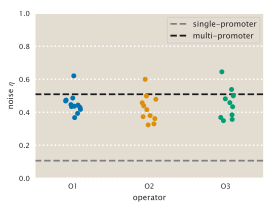

In [52]:
# Extract theoretical noise for the ∆lacI strain
noise_delta_thry = df_constraints[df_constraints.repressor == 0].p_noise.mean()
noise_delta_thry_single = df_constraints_single\
                         [df_constraints_single.repressor == 0].p_noise.mean()

# Initialize figure
fig = plt.figure(figsize=(4, 3))

# Define colors for operators
col_list = ['Blues_r', 'Reds_r', 'Greens_r']
colors = [sns.color_palette(x, n_colors=1) for x in col_list]

# Plot theoretical prediction

# Generate stripplot for experimentally determined 
# noise of the ∆lacI strain
sns.stripplot(x='operator', y='noise',
            order=['O1', 'O2', 'O3'], data=df_noise_delta)

# Plot theoretical prediction as a horizontal black line
plt.axhline(noise_delta_thry_single, color='gray', linestyle='--',
            label='single-promoter')
plt.axhline(noise_delta_thry, color='k', linestyle='--',
            label='multi-promoter')

# Include legend
plt.legend()

# Set axis limits
plt.ylim([0, 1])

# Label axis
plt.ylabel(r'noise $\eta$')


# Save figure
plt.tight_layout()
plt.savefig(figdir + 'noise_delta_microscopy.pdf', bbox_inches='tight')

### Regulated promoter

Let's extend the analysis to the regulated promoter. Again we will take the single-cell intensity measurements, extract the auto fluorescence and compute the noise $\eta$.

In [53]:
# group by date and by IPTG concentration
df_group = df_micro.groupby(['date'])

# Define names for columns of data frame
names = ['date', 'IPTG_uM','operator', 'binding_energy',
         'rbs', 'repressors', 'mean', 'std', 'noise']
# Initialize data frame to save the noise
df_noise = pd.DataFrame(columns=names)
for date, data in df_group:
    # Extract the mean autofluorescence
    I_auto = data[data.rbs == 'auto'].intensity.mean()
    
    # Extract the strain fluorescence measurements
    strain_data = data[(data.rbs != 'auto') & (data.rbs != 'delta')]
    
    # Group data by IPTG measurement
    data_group = strain_data.groupby('IPTG_uM')
    for inducer, data_inducer in data_group:
        # Append the require info
        strain_info = [date, inducer, data_inducer.operator.unique()[0],
                       data_inducer.binding_energy.unique()[0],
                       data_inducer.rbs.unique()[0],
                       data_inducer.repressors.unique()[0] * 2, # for tetramers
                      (data_inducer.intensity - I_auto).mean(), 
                      (data_inducer.intensity - I_auto).std(ddof=1)]
        # Compute the noise
        strain_info.append(strain_info[-1] / strain_info[-2])
        # Convert to a pandas series to attach to the dataframe
        strain_info = pd.Series(strain_info, index=names)
        # Append to the info to the data frame
        df_noise = df_noise.append(strain_info, ignore_index=True)
    
df_noise = df_noise.sort_values('repressors')
df_noise.head()

date  IPTG_uM operator  binding_energy    rbs repressors  \
59  20180321   5000.0       O2           -13.9  HG104         22   
69  20180326    500.0       O2           -13.9  HG104         22   
68  20180326    250.0       O2           -13.9  HG104         22   
67  20180326    100.0       O2           -13.9  HG104         22   
66  20180326     75.0       O2           -13.9  HG104         22   

            mean          std     noise  
59  14885.655306  6491.858248  0.436115  
69   8986.806998  3775.253375  0.420088  
68   9474.339262  4248.771772  0.448450  
67   8929.806241  3942.619517  0.441512  
66   8834.275317  3720.672366  0.421163

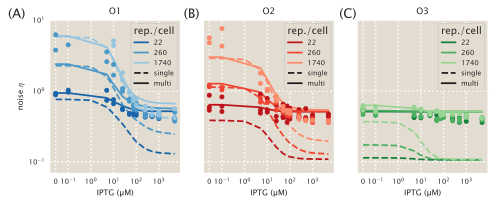

In [54]:
# Define repressor copy numbers to include
rep = df_noise['repressors'].unique()

# Group moments by operator and repressor 
df_group_exp = df_noise.sort_values('IPTG_uM').\
               groupby(['operator', 'repressors'])
df_group = df_constraints[df_constraints['repressor'].isin(rep)].\
           sort_values('inducer_uM').\
           groupby(['operator', 'repressor'])
df_group_single = df_constraints_single[df_constraints_single['repressor'].isin(rep)].\
                  sort_values('inducer_uM').\
                  groupby(['operator', 'repressor'])

# Generate index for each opeartor
operators = ['O1', 'O2', 'O3']
op_idx = dict(zip(operators, np.arange(3)))

# Generate list of colors
col_list = ['Blues_r', 'Reds_r', 'Greens_r']
# Loop through operators generating dictionary of colors for each
col_dict = {}
for i, op in enumerate(operators):
    col_dict[op] = dict(zip(rep, sns.color_palette(col_list[i], n_colors=len(rep) + 1)[0:3]))

# Initialize figure
fig, ax = plt.subplots(1, 3, figsize=(7, 3), sharex=True, sharey=True)

# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    ax[op_idx[group[0]]].plot(data.inducer_uM, data.p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))

# Loop through groups on single-promoter
for i, (group, data) in enumerate(df_group_single):
    ax[op_idx[group[0]]].plot(data.inducer_uM, data.p_noise, linestyle='--',
                              color=col_dict[group[0]][group[1]],
                              label='')

# Loop through groups on single-promoter
for i, (group, data) in enumerate(df_group_exp):
    ax[op_idx[group[0]]].plot(data.IPTG_uM, data.noise, linestyle='--',
                              color=col_dict[group[0]][group[1]],
                              label='', lw=0, marker='o', markersize=4)


for i, a in enumerate(ax):
    # Generate legend for single vs double promoter
    ax[i].plot([], [], color='k', linestyle='--', label='single')
    ax[i].plot([], [], color='k', label='multi')
    # systematically change axis for all subplots
    ax[i].set_xscale('symlog', linthreshx=1E-1, linscalex=0.5)
    ax[i].set_yscale('log')
    ax[i].set_ylim(top=10)
    # Set legend
    ax[i].legend(title='rep./cell', fontsize=7)
 
    # Set title
    ax[i].set_title(operators[i])
    # Label axis
    ax[i].set_xlabel(r'IPTG (µM)')
ax[0].set_ylabel(r'noise $\eta$')

# Label plots with letters
plt.figtext(0.01, 0.9, '(A)', fontsize=13)
plt.figtext(0.36, 0.9, '(B)', fontsize=13)
plt.figtext(0.67, 0.9, '(C)', fontsize=13)
   
plt.tight_layout()
plt.savefig(figdir + 'noise_comparison_exp.pdf', bbox_inches='tight')

---
---

#### Computing the Maximum entropy distribution

Having computed the constraints let's go ahead and perform the MaxEnt optimization to obtain the Lagrange multipliers.

In [49]:
# Define index of moments to be used in the computation
moments = [(1, 0), (2, 0), (3, 0),
           (0, 1), (1, 1), (0, 2),
           (2, 1), (1, 2), (0, 3)]

# Define sample space
mRNA_space = np.arange(0, 50)
protein_space = np.arange(0, 2.5E4)
# Generate sample space as a list of pairs using itertools.
samplespace = list(itertools.product(mRNA_space, protein_space))

# Initialize matrix to save all the features that are fed to the
# maxentropy function
features = np.zeros([len(moments), len(samplespace)])

# Loop through constraints and compute features
for i, mom in enumerate(moments):
    features[i, :] = [chann_cap.feature_fn(x, mom) for x in samplespace]

In [ ]:
# Load the constraints
df_constraints = pd.read_csv(datadir + 'MaxEnt_multi_promoter_cell_division_constraints_HGstrains.csv')

# Initialize data frame to save the lagrange multipliers.
names = ['operator', 'binding_energy', 'repressor', 'inducer_uM']

names = names + ['lambda_m' + str(m[0]) + 'p' + str(m[1]) for m in moments]

df_maxEnt = pd.DataFrame([], columns=names)

# Define column names containing the constraints used to fit the distribution
constraints_names = ['m' + str(m[0]) + 'p' + str(m[1]) for m in moments]

fit_dist = True
if fit_dist:
    # Define function for parallel computation
    def maxEnt_parallel(idx, df):
        # Report on progress
        print('iteration: ',idx)
            
        # Extract constraints
        constraints = df.loc[constraints_names]
        
        # Perform MaxEnt computation
        Lagrange = chann_cap.MaxEnt_bretthorst(constraints, features, 
                                               algorithm='BFGS')
        # Save Lagrange multipliers into dataframe
        series = pd.Series(Lagrange, index=names[4::])
        
        # Add other features to series before appending to dataframe
        series = pd.concat([df.drop(constraints_names), series])
        
        return series
    
    # Run the function in parallel
    maxEnt_series = Parallel(n_jobs=6)(delayed(maxEnt_parallel)(idx, df)
                           for idx, df in df_constraints.iterrows())
    
    # Initialize data frame to save list of parameters
    df_maxEnt = pd.DataFrame([], columns=names)

    for s in maxEnt_series:
        df_maxEnt = df_maxEnt.append(s, ignore_index=True)

    df_maxEnt.to_csv(datadir +
                     'MaxEnt_ss_Lagrange_multipliers_cell_division_HGstrains.csv')
    
df_maxEnt = pd.read_csv(datadir +
                     'MaxEnt_ss_Lagrange_multipliers_cell_division_HGstrains.csv')
df_maxEnt.head()

#### Computing the Maximum entropy distribution

Having computed the constraints let's go ahead and perform the MaxEnt optimization to obtain the Lagrange multipliers.

In [46]:
# Define index of moments to be used in the computation
# moments = [(1, 0), (2, 0), (3, 0),
#            (0, 1), (1, 1), (0, 2),
#            (2, 1), (1, 2), (0, 3)]
# moments = [(0, 1), (0, 2)]
moments = [(0, 1), (0, 2), (0, 3)]

# Define sample space
# mRNA_space = np.arange(0, 80)
mRNA_space = np.array([0])
protein_space = np.arange(0, 4E4)

# Generate sample space as a list of pairs using itertools.
samplespace = list(itertools.product(mRNA_space, protein_space))

# Initialize matrix to save all the features that are fed to the
# maxentropy function
features = np.zeros([len(moments), len(samplespace)])

# Loop through constraints and compute features
for i, mom in enumerate(moments):
    features[i, :] = [chann_cap.feature_fn(x, mom) for x in samplespace]

In [53]:
# Initialize data frame to save the lagrange multipliers.
names = ['operator', 'binding_energy', 'repressor', 'inducer_uM']

names = names + ['lambda_m' + str(m[0]) + 'p' + str(m[1]) for m in moments]

df_maxEnt = pd.DataFrame([], columns=names)

# Define column names containing the constraints used to fit the distribution
constraints_names = ['m' + str(m[0]) + 'p' + str(m[1]) for m in moments]

fit_dist = True
if fit_dist:
    # Define function for parallel computation
    def maxEnt_parallel(idx, df):
        # Report on progress
        print('iteration: ',idx)
            
        # Extract constraints
        constraints = df.loc[constraints_names]
        
        # Perform MaxEnt computation
        Lagrange = chann_cap.MaxEnt_bretthorst(constraints, features, 
                                               algorithm='Powell')
        # Save Lagrange multipliers into dataframe
        series = pd.Series(Lagrange, index=names[4::])
        
        # Add other features to series before appending to dataframe
        series = pd.concat([df.drop(constraints_names), series])
        
        return series
    
    # Run the function in parallel
    maxEnt_series = Parallel(n_jobs=6)(delayed(maxEnt_parallel)(idx, df)
                           for idx, df in df_constraints.iterrows())
    
    # Initialize data frame to save list of parameters
    df_maxEnt = pd.DataFrame([], columns=names)

    for s in maxEnt_series:
        df_maxEnt = df_maxEnt.append(s, ignore_index=True)

    df_maxEnt.to_csv(datadir + 
                     'MaxEnt_ss_Lagrange_multipliers_cell_division_expo_dist_100min_3mom.csv', index=False)
    
df_maxEnt = pd.read_csv(datadir +
            'MaxEnt_ss_Lagrange_multipliers_cell_division_expo_dist_100min_3mom.csv')
df_maxEnt.head()

operator  binding_energy  repressor  inducer_uM  lambda_m0p1   lambda_m0p2  \
0       O1           -15.3        0.0         0.0     0.000314 -1.612388e-08   
1       O1           -15.3        0.0         0.1     0.000314 -1.612388e-08   
2       O1           -15.3        0.0         5.0     0.000314 -1.612388e-08   
3       O1           -15.3        0.0        10.0     0.000314 -1.612388e-08   
4       O1           -15.3        0.0        25.0     0.000314 -1.612388e-08   

    lambda_m0p3       m1p0           m1p1          m1p2       m2p0  \
0 -2.816620e-13  14.411945  127700.332069  1.362401e+09  281.16823   
1 -2.816620e-13  14.411945  127700.332069  1.362401e+09  281.16823   
2 -2.816620e-13  14.411945  127700.332069  1.362401e+09  281.16823   
3 -2.816620e-13  14.411945  127700.332069  1.362401e+09  281.16823   
4 -2.816620e-13  14.411945  127700.332069  1.362401e+09  281.16823   

           m2p1         m3p0  
0  2.643869e+06  6919.633836  
1  2.643869e+06  6919.633836  
2  2.643869e+06  6919.633836  
3  2.643869e+06  6919.633836  
4  2.643869e+06  6919.633836

Let's look at some of these distributions.

No handles with labels found to put in legend.


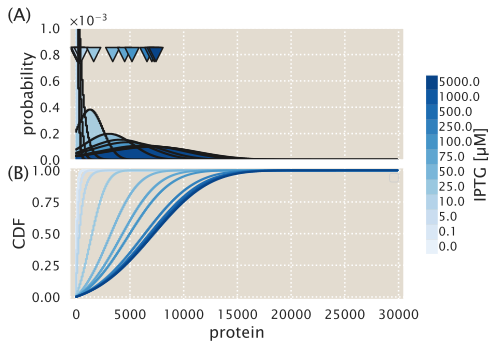

In [54]:
# Define sample space
mRNA_space = np.array([0])
# mRNA_space = np.arange(0, 50)
protein_space = np.arange(0, 3E4)

# Extract the multipliers for a specific strain
df_sample = df_maxEnt[(df_maxEnt.operator == 'O2') &
                      (df_maxEnt.repressor == 260)]

# Group multipliers by inducer concentration
df_group = df_sample.groupby('inducer_uM')

# Initialize matrix to save probability distributions
Pp = np.zeros([len(df_group), len(protein_space)])

# Loop through each of the entries
for i, (group, data) in enumerate(df_group):
    # Select the Lagrange multipliers
    lagrange_sample =  data.loc[:, [col for col in data.columns 
                                         if 'lambda' in col]].values[0]

    # Compute distribution from Lagrange multipliers values
    Pp[i, :] = chann_cap.maxEnt_from_lagrange(mRNA_space, protein_space, lagrange_sample,
                                              exponents=[(0, 1), (0, 2), (0, 3)]).T

chann_cap.pmf_cdf_plot(protein_space, Pp, df_group.groups, binstep=100,
                       xlabel='protein', cbar_label='IPTG [µM]', 
                       ylim=[0, 1E-3], marker_height=8E-4)

No handles with labels found to put in legend.


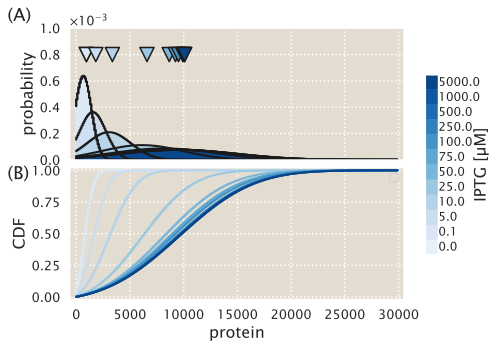

In [55]:
# Define sample space
mRNA_space = np.array([0])
protein_space = np.arange(0, 3E4)

# Extract the multipliers for a specific strain
df_sample = df_maxEnt[(df_maxEnt.operator == 'O3') &
                      (df_maxEnt.repressor == 1740)]

# Group multipliers by inducer concentration
df_group = df_sample.groupby('inducer_uM')

# Initialize matrix to save probability distributions
Pp = np.zeros([len(df_group), len(protein_space)])

# Loop through each of the entries
for i, (group, data) in enumerate(df_group):
    # Select the Lagrange multipliers
    lagrange_sample =  data.loc[:, [col for col in data.columns 
                                         if 'lambda' in col]].values[0]

    # Compute distribution from Lagrange multipliers values
    Pp[i, :] = chann_cap.maxEnt_from_lagrange(mRNA_space, protein_space, lagrange_sample,
                                              exponents=[(0, 1), (0, 2)]).T

chann_cap.pmf_cdf_plot(protein_space, Pp, df_group.groups, binstep=100,
                       xlabel='protein', cbar_label='IPTG [µM]', 
                       ylim=[0, 1E-3], marker_height=8E-4)

No handles with labels found to put in legend.


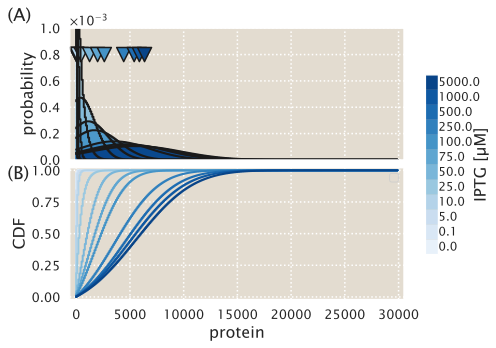

In [56]:
# Define sample space
mRNA_space = np.array([0])
protein_space = np.arange(0, 3E4)

# Extract the multipliers for a specific strain
df_sample = df_maxEnt[(df_maxEnt.operator == 'O1') &
                      (df_maxEnt.repressor == 260)]

# Group multipliers by inducer concentration
df_group = df_sample.groupby('inducer_uM')

# Initialize matrix to save probability distributions
Pp = np.zeros([len(df_group), len(protein_space)])

# Loop through each of the entries
for i, (group, data) in enumerate(df_group):
    # Select the Lagrange multipliers
    lagrange_sample =  data.loc[:, [col for col in data.columns 
                                         if 'lambda' in col]].values[0]

    # Compute distribution from Lagrange multipliers values
    Pp[i, :] = chann_cap.maxEnt_from_lagrange(mRNA_space, protein_space, lagrange_sample,
                                              exponents=[(0, 1), (0, 2)]).T

chann_cap.pmf_cdf_plot(protein_space, Pp, df_group.groups, binstep=100,
                       xlabel='protein', cbar_label='IPTG [µM]', 
                       ylim=[0, 1E-3], marker_height=8E-4)

# Compare to experimental data

Let's now take a look at the experimental data to compare it with these theoretical predictions.

Let's first load the data into memory.

In [316]:
# Read the tidy-data frame
# mwc_files = glob.glob('../../data/csv_microscopy/mwc_data/*csv')
files = glob.glob('../../data/csv_microscopy/*csv')# + mwc_files
df_micro = pd.concat(pd.read_csv(f, comment='#') for f in files if 'Oid' not in f)

# Compute the total intensity by multiplying area times mean intensity
df_micro.loc[:, 'intensity'] = df_micro['area'] * df_micro['mean_intensity']
df_micro[['date', 'operator', 'rbs', 'mean_intensity', 'intensity']].head()

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


date operator   rbs  mean_intensity   intensity
0  20161204       O3  auto       52.562979  137.252451
1  20161204       O3  auto       53.070565  142.653678
2  20161204       O3  auto       52.323744  221.015495
3  20161204       O3  auto       51.013142  174.995484
4  20161204       O3  auto       44.325267  166.804845

## Normalizing data by $\left\langle \Delta lacI \right\rangle$.

In order to make the x axis comparable we will normalize each data set by the mean fluorescence value of the $\Delta lacI$ strain, and will do the same for the theoretical results.

In [317]:
# Compute the mean autofluorescence for each experimental data set
df_auto_mean = df_micro[df_micro.rbs == 'auto'].groupby(['date'])[['mean_intensity', 'intensity']].mean()

# Compute the mean ∆lacI fluorescence for each expeirmental data set
df_delta_mean = df_micro[df_micro.rbs == 'delta'].groupby(['date'])[['mean_intensity', 'intensity']].mean()

# Extract the raw data of regulated repressors
df = df_micro[(df_micro.rbs != 'auto') & (df_micro.rbs != 'delta')]

# Add column with auto and ∆lacI values for both total and mean intensity
df.loc[:, 'auto_mean'] = df_auto_mean.loc[df.date, 'mean_intensity'].values
df.loc[:, 'auto_tot'] = df_auto_mean.loc[df.date, 'intensity'].values
df.loc[:, 'delta_mean'] = df_delta_mean.loc[df.date, 'mean_intensity'].values
df.loc[:, 'delta_tot'] = df_delta_mean.loc[df.date, 'intensity'].values

# Add the normalized intensity column
df.loc[:, 'norm_intensity_mean'] = (df.mean_intensity - df.auto_mean) /\
                              (df.delta_mean - df.auto_mean)
df.loc[:, 'norm_intensity_tot'] = (df.intensity - df.auto_tot) /\
                              (df.delta_tot - df.auto_tot)

df.head()

/Users/razo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/razo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


IPTG_uM    area  binding_energy      date  eccentricity  mean_intensity  \
789      0.0  4.5568            -9.7  20161204      0.961987     4386.890286   
790      0.0  4.0704            -9.7  20161204      0.950957     6799.280198   
791      0.0  3.8656            -9.7  20161204      0.958037     3575.847218   
792      0.0  3.4816            -9.7  20161204      0.931967     3794.091754   
793      0.0  3.9168            -9.7  20161204      0.948831     4030.448647   

    operator      rbs  repressors  solidity  username     intensity  \
789       O3  RBS1027       130.0  0.898990  mrazomej  19990.181656   
790       O3  RBS1027       130.0  0.903409  mrazomej  27675.790117   
791       O3  RBS1027       130.0  0.898810  mrazomej  13822.795007   
792       O3  RBS1027       130.0  0.944444  mrazomej  13209.509850   
793       O3  RBS1027       130.0  0.905325  mrazomej  15786.461261   

     auto_mean    auto_tot   delta_mean     delta_tot  norm_intensity_mean  \
789  57.246449  211.360581  5484.053817  20091.431082             0.797825   
790  57.246449  211.360581  5484.053817  20091.431082             1.242357   
791  57.246449  211.360581  5484.053817  20091.431082             0.648374   
792  57.246449  211.360581  5484.053817  20091.431082             0.688590   
793  57.246449  211.360581  5484.053817  20091.431082             0.732144   

     norm_intensity_tot  
789            0.994907  
790            1.381506  
791            0.684677  
792            0.653828  
793            0.783453

Let's look at one of these strains to make sure that the computation worked.

First let's compare the fold-change computed from the mean intensity vs. the total intensity.

/Users/razo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


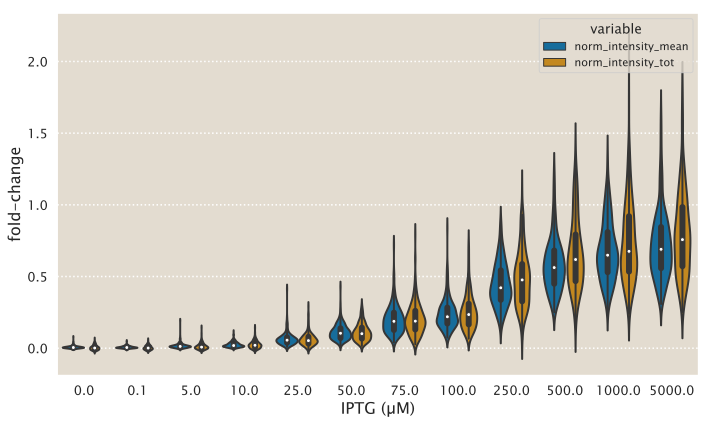

In [318]:
# Generate data frame in long format
df_example = df.loc[df.date == 20180402,
                    ('IPTG_uM', 'norm_intensity_mean', 'norm_intensity_tot')]

# Melt data frame into long format in order to use it
# with Violin plot function
df_example = pd.melt(df_example, id_vars=['IPTG_uM'])

# Initialize figure
fig = plt.figure(figsize=(10, 6))
sns.violinplot(x='IPTG_uM', y='value', hue='variable', data=df_example)
plt.xlabel('IPTG (µM)')
plt.ylabel('fold-change')
plt.tight_layout()

Text(0,0.5,'ECDF')

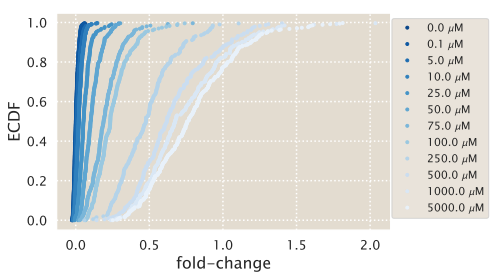

In [319]:
# Plot example experimental data

df_example = df[df.date == 20180402]

# List the unique concentrations for this strain
concentrations = df_example.IPTG_uM.unique()

# Set a color pallete for each concentration
colors = sns.color_palette("Blues_r", n_colors=len(concentrations))

# Group data frame by concentration
df_group = df_example.groupby('IPTG_uM')

# Initialize figure
fig, ax = plt.subplots(1, 1)

# Loop through concentrations plotting the ECDF at each step
for i, (c, data) in enumerate(df_group):
    # ECDF Plot
    x, y = chann_cap.ecdf(data.norm_intensity_tot)
    ecdf_plot = ax.plot(x, y, '.', label=str(c) + r' $\mu$M', color=colors[i])

ax.legend(bbox_to_anchor=(1.31, 1.0))
    
ax.set_xlabel('fold-change')
ax.set_ylabel('ECDF')

Let's now plot the same ECDF along with the normalized CDF predictions.

First we build the theoretical distribution from the Lagrange multipliers.

In [320]:
# Define sample space
mRNA_space = np.array([0])
protein_space = np.arange(0, 3E4)

# Extract the multipliers for a specific strain
df_sample = df_maxEnt[(df_maxEnt.operator == df_example.operator.unique()[0]) &
                      (df_maxEnt.repressor == df_example.repressors.unique()[0])]

# Group multipliers by inducer concentration
df_group = df_sample.groupby('inducer_uM')

# Initialize matrix to save probability distributions
Pp = np.zeros([len(df_group), len(protein_space)])

# Initialize array to save mean fold-change
fc_cme = np.zeros(len(df_group))

# Loop through each of the entries
for i, (group, data) in enumerate(df_group):
    # Select the Lagrange multipliers
    lagrange_sample =  data.loc[:, [col for col in data.columns 
                                         if 'lambda' in col]].values[0]

    # Compute distribution from Lagrange multipliers values
    Pp[i, :] = chann_cap.maxEnt_from_lagrange(mRNA_space, protein_space, lagrange_sample,
                                              exponents=[(0, 1), (0, 2), (0, 3)]).T
    # Compute mean fold-change
    fc_cme[i] = sum(Pp[i, :] * protein_space) / p_mean_unreg

Now we plot the ECDF along with the theoretical CDF.

Text(0,0.5,'ECDF')

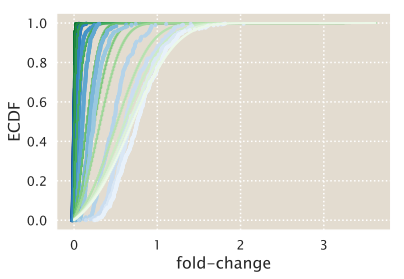

In [321]:
# List the unique concentrations for this strain
concentrations = df_example.IPTG_uM.unique()

# Set a color pallete for each concentration
exp_colors = sns.color_palette("Blues_r", n_colors=len(concentrations))
thry_colors = sns.color_palette("Greens_r", n_colors=len(concentrations))

# Group data frame by concentration
df_group = df_example.groupby('IPTG_uM')

# Define binstep not to use all bins to render the plot
binstep = 100

# Initialize figure
fig, ax = plt.subplots(1, 1)
# Loop through concentrations
for i, (c, data) in enumerate(df_group):
    # ECDF Plot
    x, y = chann_cap.ecdf(data.norm_intensity_tot)
    ecdf_plot = ax.plot(x, y, '.', label=str(c) + r' $\mu$M', color=exp_colors[i])

    # CDF plot
    ax.plot(protein_space[0::binstep] / p_mean_unreg, 
            np.cumsum(Pp[i, :])[0::binstep],
            drawstyle='steps', color=thry_colors[i], linewidth=2) 

# ax.legend(bbox_to_anchor=(1.31, 1.0))
    
ax.set_xlabel('fold-change')
ax.set_ylabel('ECDF')

It is hard to make a clear comparision between these distributions. What we will try instead is to generate a *violin plot*. For this we will generate random samples for the theoretical prediction since the python functions take samples rather than PMFs to then apply KDE on these samples.

As a trial let's first plot the *violin plot* of only the data

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


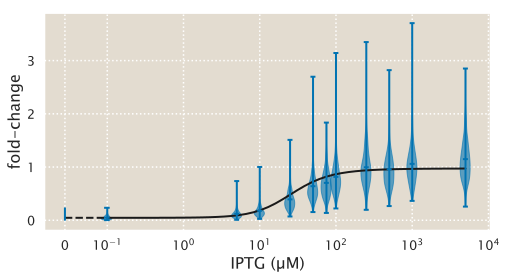

In [247]:
##  Compute thermodynamic fold-change  ##
# Extract the repressor copy number and binding energy
eRA = df_example.binding_energy.unique()
R = df_example.repressors.unique() * 2

# Define range for theoretical fold-change
iptg_array = np.logspace(-1, np.log10(5000))
iptg_lin = [0, 0.1]

# Compute theoretical fold-change
fc_thry = chann_cap.fold_change_statmech(iptg_array, R, eRA, ka, ki)
fc_thry_lin = chann_cap.fold_change_statmech(iptg_lin, R, eRA, ka, ki)

# Initialize figure
fig, ax = plt.subplots(figsize=(8, 4))

##  Plot thermodynamic fold-change  ##
ax.plot(iptg_array, fc_thry, color='k', zorder=1)
ax.plot(iptg_lin, fc_thry_lin, color='k', linestyle='--', zorder=1)

# Group data by concentrations
df_group = df_example.groupby('IPTG_uM')

##  Plot violin plots of titration curves  ##
# Define width of the violin plot and transform into log scale
w = 0.13
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
# Loop through each concentration and plot the violin plot
for i, (c, data) in enumerate(df_group):
    # Define position
    position = np.array([c])
    # Generate violin plot
    vplot = ax.violinplot(data.norm_intensity, position,
                          widths=width(position, w), showmeans=True)
    # Change color (weird matplotlib way of dealing with this)
    for vp in vplot['bodies']:
        vp.set_color('b')
        vp.set_edgecolor('b')
        vp.set_alpha(0.6)
    for partname in ('cbars','cmins','cmaxes','cmeans'):
        vp = vplot[partname]
        vp.set_edgecolor('b')
        vp.set_linewidth(2)

# Set axis labels
ax.set_xlabel('IPTG (µM)')
ax.set_ylabel('fold-change')
   
# Set xaxis as hyperlog
ax.set_xscale('symlog', linthreshx=1E-1, linscalex=0.5)

As a sanity check, let's compute the mean fold-change and plot it against the theoretical prediction from the statistical mechanical model.

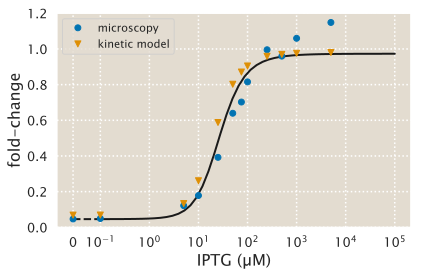

In [200]:
# Group values by IPTG concentration and compute the mean fold-change
df_fc = df_example.groupby('IPTG_uM').norm_intensity.mean()

# Extract the repressor copy number and binding energy
eRA = df_example.binding_energy.unique()
R = df_example.repressors.unique() * 2

# Define range for theoretical fold-change
iptg_array = np.logspace(-1, 5)
iptg_lin = [0, 0.1]

# Compute theoretical fold-change
fc_thry = chann_cap.fold_change_statmech(iptg_array, R, eRA, ka, ki)
fc_thry_lin = chann_cap.fold_change_statmech(iptg_lin, R, eRA, ka, ki)

# Plot theoretical fold-change
plt.plot(iptg_array, fc_thry, color='k')
plt.plot(iptg_lin, fc_thry_lin, color='k', linestyle='--')

# Plot fold-change vs IPTG concentration
plt.plot(df_fc.index.values, df_fc.values, lw=0, marker='o', 
         label='microscopy')
plt.plot(df_fc.index.values, fc_cme, lw=0, marker='v',
         label='kinetic model')

# Set axis labels
plt.xlabel('IPTG (µM)')
plt.ylabel('fold-change')

# Set xaxis as hyperlog
plt.xscale('symlog', linthreshx=1E-1, linscalex=0.5)

# Set y axis limits
plt.ylim([0, 1.2])

plt.legend()
plt.tight_layout()